In [471]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import sys
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import torch

from sklearn.preprocessing import LabelEncoder

Checklist
- ensure no data leakage
    - rolling averages calculated correctly
    - no information leak from standardization
- Identify why win rate != model accuracy
    - correctly implemented betting strategy?
    - correct model used
    - correctly calculated model accuracy
- Determine why simulation had such high ROI
    - probability of bankruptcy with 60% win rate using 1/8th kelly (find paper?)
- Remove uninformative features
    - remove avg odds o/u
    - try with only top 3 features

# Load Data

In [472]:
raw_data = pd.read_csv('../data/combined/full_raw_data.csv')
raw_vegas = pd.read_csv('../data/combined/full_vegas_data.csv')

In [473]:
pd.set_option('display.max_columns', None)

In [474]:
raw_data.head()

,Date,GAME_SEQUENCE,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_WINS_LOSSES,PTS_QTR1,PTS_QTR2,PTS_QTR3,PTS_QTR4,PTS_OT1,PTS_OT2,PTS_OT3,PTS_OT4,PTS_OT5,PTS_OT6,PTS_OT7,PTS_OT8,PTS_OT9,PTS_OT10,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,TOV,YEAR,GAME_DATE_EST
0,2012-10-30,1,21200001,1610612764,WAS,Washington,0-1,24,15,23,22,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,84,0.356,0.600,0.250,26,39,12,2012-2013,NaN
1,2012-10-30,1,21200001,1610612739,CLE,Cleveland,1-0,31,19,24,20,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,94,0.456,0.682,0.350,22,54,20,2012-2013,NaN
2,2012-10-30,2,21200002,1610612738,BOS,Boston,0-1,25,29,22,31,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,107,0.520,0.821,0.462,24,41,15,2012-2013,NaN
3,2012-10-30,2,21200002,1610612748,MIA,Miami,1-0,31,31,31,27,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,120,0.544,0.813,0.500,25,36,8,2012-2013,NaN
4,2012-10-30,3,21200003,1610612742,DAL,Dallas,1-0,25,23,26,25,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,99,0.471,0.778,0.333,22,40,11,2012-2013,NaN


In [475]:
raw_vegas.head()

,Date,Location,Team,OppTeam,TeamId,GameId,PercentBet_ML,Open_Line_ML,Pinnacle_ML,5dimes_ML,Heritage_ML,Bovada_ML,Betonline_ML,Average_Line_ML,Best_Line_ML,Worst_Line_ML,PercentBet_Spread,Open_Line_Spread,Open_Odds_Spread,Pinnacle_Line_Spread,Pinnacle_Odds_Spread,5dimes_Line_Spread,5dimes_Odds_Spread,Heritage_Line_Spread,Heritage_Odds_Spread,Bovada_Line_Spread,Bovada_Odds_Spread,Betonline_Line_Spread,Betonline_Odds_Spread,Average_Line_Spread,Average_Odds_Spread,Best_Line_Spread,Worst_Line_Spread,Best_Odds_Spread,Worst_Odds_Spread,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,5dimes_Line_OU,5dimes_Odds_OU,Heritage_Line_OU,Heritage_Odds_OU,Bovada_Line_OU,Bovada_Odds_OU,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Pts,Spread,Result,Total,YEAR
0,2012-10-30,away,Washington,Cleveland,1610612764,21200001,44.6,220.0,210.0,200.0,210.0,215.0,210.0,209.0,215.0,200.0,44.4,5.0,-110.0,6.0,-105.0,6.0,-110.0,6.0,-110.0,6.0,-105.0,6.0,-108.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,47.3,187.0,-110.0,191.0,-104.0,191.0,-110.0,191.0,-110.0,191.0,-105.0,191.0,-110.0,190.33,-108.17,191.0,187.0,-104.0,-110.0,84.0,-10.0,L,178.0,2012-2013
1,2012-10-30,home,Cleveland,Washington,1610612739,21200001,55.4,-260.0,-235.0,-240.0,-250.0,-255.0,-250.0,-246.0,-235.0,-255.0,55.6,-5.0,-110.0,-6.0,-105.0,-6.0,-110.0,-6.0,-110.0,-6.0,-115.0,-6.0,-112.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,191.0,-106.0,191.0,-110.0,191.0,-110.0,191.0,-115.0,191.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,W,178.0,2012-2013
2,2012-10-30,away,Boston,Miami,1610612738,21200002,44.8,220.0,244.0,240.0,230.0,225.0,235.0,234.8,244.0,225.0,48.2,7.5,-110.0,6.5,-105.0,6.0,-101.0,6.0,-110.0,7.0,-115.0,6.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,51.6,182.0,-110.0,187.5,-105.0,187.5,-104.0,187.5,-110.0,188.0,-105.0,187.0,-110.0,186.58,-107.33,188.0,182.0,-104.0,-110.0,107.0,-13.0,L,227.0,2012-2013
3,2012-10-30,home,Miami,Boston,1610612748,21200002,55.2,-260.0,-275.0,-260.0,-270.0,-265.0,-280.0,-270.0,-260.0,-280.0,51.8,-7.5,-110.0,-6.5,-105.0,-6.0,-109.0,-6.0,-110.0,-7.0,-105.0,-6.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,187.5,-105.0,187.5,-106.0,187.5,-110.0,188.0,-115.0,187.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,W,227.0,2012-2013
4,2012-10-30,away,Dallas,L.A. Lakers,1610612742,21200003,40.8,350.0,393.0,420.0,400.0,375.0,385.0,394.6,420.0,375.0,49.0,9.5,-110.0,8.5,-103.0,8.5,-105.0,8.5,-110.0,9.0,-105.0,8.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,42.6,185.0,-110.0,186.0,-100.0,186.0,-105.0,185.5,-110.0,187.0,-110.0,186.5,-110.0,186.00,-107.50,187.0,185.0,-100.0,-110.0,99.0,8.0,W,190.0,2012-2013


In [476]:
# combine the two datasets and drop where raw_vegas with full join
combined_data = pd.merge(raw_data, raw_vegas, left_on=['GAME_ID', 'TEAM_ID'], right_on = ['GameId', 'TeamId'], how='outer')
combined_data.head()

,Date_x,GAME_SEQUENCE,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_WINS_LOSSES,PTS_QTR1,PTS_QTR2,PTS_QTR3,PTS_QTR4,PTS_OT1,PTS_OT2,PTS_OT3,PTS_OT4,PTS_OT5,PTS_OT6,PTS_OT7,PTS_OT8,PTS_OT9,PTS_OT10,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,TOV,YEAR_x,GAME_DATE_EST,Date_y,Location,Team,OppTeam,TeamId,GameId,PercentBet_ML,Open_Line_ML,Pinnacle_ML,5dimes_ML,Heritage_ML,Bovada_ML,Betonline_ML,Average_Line_ML,Best_Line_ML,Worst_Line_ML,PercentBet_Spread,Open_Line_Spread,Open_Odds_Spread,Pinnacle_Line_Spread,Pinnacle_Odds_Spread,5dimes_Line_Spread,5dimes_Odds_Spread,Heritage_Line_Spread,Heritage_Odds_Spread,Bovada_Line_Spread,Bovada_Odds_Spread,Betonline_Line_Spread,Betonline_Odds_Spread,Average_Line_Spread,Average_Odds_Spread,Best_Line_Spread,Worst_Line_Spread,Best_Odds_Spread,Worst_Odds_Spread,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,5dimes_Line_OU,5dimes_Odds_OU,Heritage_Line_OU,Heritage_Odds_OU,Bovada_Line_OU,Bovada_Odds_OU,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Pts,Spread,Result,Total,YEAR_y
0,2012-10-30,1,21200001,1610612739,CLE,Cleveland,1-0,31,19,24,20,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,94,0.456,0.682,0.350,22,54,20,2012-2013,NaN,2012-10-30,home,Cleveland,Washington,1.610613e+09,21200001.0,55.4,-260.0,-235.0,-240.0,-250.0,-255.0,-250.0,-246.0,-235.0,-255.0,55.6,-5.0,-110.0,-6.0,-105.0,-6.0,-110.0,-6.0,-110.0,-6.0,-115.0,-6.0,-112.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,191.0,-106.0,191.0,-110.0,191.0,-110.0,191.0,-115.0,191.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,W,178.0,2012-2013
1,2012-10-30,1,21200001,1610612764,WAS,Washington,0-1,24,15,23,22,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,84,0.356,0.600,0.250,26,39,12,2012-2013,NaN,2012-10-30,away,Washington,Cleveland,1.610613e+09,21200001.0,44.6,220.0,210.0,200.0,210.0,215.0,210.0,209.0,215.0,200.0,44.4,5.0,-110.0,6.0,-105.0,6.0,-110.0,6.0,-110.0,6.0,-105.0,6.0,-108.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,47.3,187.0,-110.0,191.0,-104.0,191.0,-110.0,191.0,-110.0,191.0,-105.0,191.0,-110.0,190.33,-108.17,191.0,187.0,-104.0,-110.0,84.0,-10.0,L,178.0,2012-2013
2,2012-10-30,2,21200002,1610612738,BOS,Boston,0-1,25,29,22,31,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,107,0.520,0.821,0.462,24,41,15,2012-2013,NaN,2012-10-30,away,Boston,Miami,1.610613e+09,21200002.0,44.8,220.0,244.0,240.0,230.0,225.0,235.0,234.8,244.0,225.0,48.2,7.5,-110.0,6.5,-105.0,6.0,-101.0,6.0,-110.0,7.0,-115.0,6.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,51.6,182.0,-110.0,187.5,-105.0,187.5,-104.0,187.5,-110.0,188.0,-105.0,187.0,-110.0,186.58,-107.33,188.0,182.0,-104.0,-110.0,107.0,-13.0,L,227.0,2012-2013
3,2012-10-30,2,21200002,1610612748,MIA,Miami,1-0,31,31,31,27,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,120,0.544,0.813,0.500,25,36,8,2012-2013,NaN,2012-10-30,home,Miami,Boston,1.610613e+09,21200002.0,55.2,-260.0,-275.0,-260.0,-270.0,-265.0,-280.0,-270.0,-260.0,-280.0,51.8,-7.5,-110.0,-6.5,-105.0,-6.0,-109.0,-6.0,-110.0,-7.0,-105.0,-6.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,187.5,-105.0,187.5,-106.0,187.5,-110.0,188.0,-115.0,187.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,W,227.0,2012-2013
4,2012-10-30,3,21200003,1610612742,DAL,Dallas,1-0,25,23,26,25,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,99,0.471,0.778,0.333,22,40,11,2012-2013,NaN,2012-10-30,away,Dallas,L.A. Lakers,1.610613e+09,21200003.0,40.8,350.0,393.0,420.0,400.0,375.0,385.0,394.6,420.0,375.0,49.0,9.5,-110.0,8.5,-103.0,8.5,-105.0,8.5,-110.0,9.0,-105.0,8.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,42.6,185.0,-110.0,186.0,-100.0,186.0,-105.0,185.5,-110.0,187.0,-110.0,186.5,-110.0,186.00,-107.50,187.0,185.0,-100.0,-110.0,99.0,8.0,W,190.0,2012-2013


In [477]:
combined_data.shape

(17226, 89)

In [478]:
combined_data.isna().sum()[['Date_x', 'Date_y', 'GAME_DATE_EST']]

Date_x           7386
Date_y             18
GAME_DATE_EST    9840
dtype: int64

In [479]:
# are there any rows where Date_x, Date_y, or GAME_DATE_EST are different?
# make a date column that uses Date_y if it is not null, otherwise use GAME_DATE_EST if not null, otherwise use Date_x
combined_data['Date'] = combined_data['Date_y'].fillna(combined_data['GAME_DATE_EST']).fillna(combined_data['Date_x'])
combined_data['Date'].isna().sum()

0

In [480]:
# move date and year column to the front and remove the other date columns
combined_data = combined_data[['Date', 'YEAR_y'] + [col for col in combined_data.columns if col not in ['Date', 'YEAR_y']]]
# drop the other date columns
combined_data = combined_data.drop(columns=['Date_x', 'Date_y', 'GAME_DATE_EST'])
combined_data.head()


,Date,YEAR_y,GAME_SEQUENCE,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_WINS_LOSSES,PTS_QTR1,PTS_QTR2,PTS_QTR3,PTS_QTR4,PTS_OT1,PTS_OT2,PTS_OT3,PTS_OT4,PTS_OT5,PTS_OT6,PTS_OT7,PTS_OT8,PTS_OT9,PTS_OT10,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,TOV,YEAR_x,Location,Team,OppTeam,TeamId,GameId,PercentBet_ML,Open_Line_ML,Pinnacle_ML,5dimes_ML,Heritage_ML,Bovada_ML,Betonline_ML,Average_Line_ML,Best_Line_ML,Worst_Line_ML,PercentBet_Spread,Open_Line_Spread,Open_Odds_Spread,Pinnacle_Line_Spread,Pinnacle_Odds_Spread,5dimes_Line_Spread,5dimes_Odds_Spread,Heritage_Line_Spread,Heritage_Odds_Spread,Bovada_Line_Spread,Bovada_Odds_Spread,Betonline_Line_Spread,Betonline_Odds_Spread,Average_Line_Spread,Average_Odds_Spread,Best_Line_Spread,Worst_Line_Spread,Best_Odds_Spread,Worst_Odds_Spread,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,5dimes_Line_OU,5dimes_Odds_OU,Heritage_Line_OU,Heritage_Odds_OU,Bovada_Line_OU,Bovada_Odds_OU,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Pts,Spread,Result,Total
0,2012-10-30,2012-2013,1,21200001,1610612739,CLE,Cleveland,1-0,31,19,24,20,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,94,0.456,0.682,0.350,22,54,20,2012-2013,home,Cleveland,Washington,1.610613e+09,21200001.0,55.4,-260.0,-235.0,-240.0,-250.0,-255.0,-250.0,-246.0,-235.0,-255.0,55.6,-5.0,-110.0,-6.0,-105.0,-6.0,-110.0,-6.0,-110.0,-6.0,-115.0,-6.0,-112.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,191.0,-106.0,191.0,-110.0,191.0,-110.0,191.0,-115.0,191.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,W,178.0
1,2012-10-30,2012-2013,1,21200001,1610612764,WAS,Washington,0-1,24,15,23,22,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,84,0.356,0.600,0.250,26,39,12,2012-2013,away,Washington,Cleveland,1.610613e+09,21200001.0,44.6,220.0,210.0,200.0,210.0,215.0,210.0,209.0,215.0,200.0,44.4,5.0,-110.0,6.0,-105.0,6.0,-110.0,6.0,-110.0,6.0,-105.0,6.0,-108.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,47.3,187.0,-110.0,191.0,-104.0,191.0,-110.0,191.0,-110.0,191.0,-105.0,191.0,-110.0,190.33,-108.17,191.0,187.0,-104.0,-110.0,84.0,-10.0,L,178.0
2,2012-10-30,2012-2013,2,21200002,1610612738,BOS,Boston,0-1,25,29,22,31,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,107,0.520,0.821,0.462,24,41,15,2012-2013,away,Boston,Miami,1.610613e+09,21200002.0,44.8,220.0,244.0,240.0,230.0,225.0,235.0,234.8,244.0,225.0,48.2,7.5,-110.0,6.5,-105.0,6.0,-101.0,6.0,-110.0,7.0,-115.0,6.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,51.6,182.0,-110.0,187.5,-105.0,187.5,-104.0,187.5,-110.0,188.0,-105.0,187.0,-110.0,186.58,-107.33,188.0,182.0,-104.0,-110.0,107.0,-13.0,L,227.0
3,2012-10-30,2012-2013,2,21200002,1610612748,MIA,Miami,1-0,31,31,31,27,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,120,0.544,0.813,0.500,25,36,8,2012-2013,home,Miami,Boston,1.610613e+09,21200002.0,55.2,-260.0,-275.0,-260.0,-270.0,-265.0,-280.0,-270.0,-260.0,-280.0,51.8,-7.5,-110.0,-6.5,-105.0,-6.0,-109.0,-6.0,-110.0,-7.0,-105.0,-6.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,187.5,-105.0,187.5,-106.0,187.5,-110.0,188.0,-115.0,187.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,W,227.0
4,2012-10-30,2012-2013,3,21200003,1610612742,DAL,Dallas,1-0,25,23,26,25,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,99,0.471,0.778,0.333,22,40,11,2012-2013,away,Dallas,L.A. Lakers,1.610613e+09,21200003.0,40.8,350.0,393.0,420.0,400.0,375.0,385.0,394.6,420.0,375.0,49.0,9.5,-110.0,8.5,-103.0,8.5,-105.0,8.5,-110.0,9.0,-105.0,8.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,42.6,185.0,-110.0,186.0,-100.0,186.0,-105.0,185.5,-110.0,187.0,-110.0,186.5,-110.0,186.00,-107.50,187.0,185.0,-100.0,-110.0,99.0,8.0,W,190.0


In [481]:
# drop rows with null values for either GAME_ID or GameId
combined_data = combined_data.dropna(subset=['GAME_ID', 'GameId'])
combined_data.shape

(17208, 87)

In [482]:
# Rename YEAR_y to Year and drop YEAR_x
combined_data = combined_data.rename(columns={'YEAR_y': 'Year'})
combined_data = combined_data.drop(columns=['YEAR_x'])
combined_data.head()

,Date,Year,GAME_SEQUENCE,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_WINS_LOSSES,PTS_QTR1,PTS_QTR2,PTS_QTR3,PTS_QTR4,PTS_OT1,PTS_OT2,PTS_OT3,PTS_OT4,PTS_OT5,PTS_OT6,PTS_OT7,PTS_OT8,PTS_OT9,PTS_OT10,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,TOV,Location,Team,OppTeam,TeamId,GameId,PercentBet_ML,Open_Line_ML,Pinnacle_ML,5dimes_ML,Heritage_ML,Bovada_ML,Betonline_ML,Average_Line_ML,Best_Line_ML,Worst_Line_ML,PercentBet_Spread,Open_Line_Spread,Open_Odds_Spread,Pinnacle_Line_Spread,Pinnacle_Odds_Spread,5dimes_Line_Spread,5dimes_Odds_Spread,Heritage_Line_Spread,Heritage_Odds_Spread,Bovada_Line_Spread,Bovada_Odds_Spread,Betonline_Line_Spread,Betonline_Odds_Spread,Average_Line_Spread,Average_Odds_Spread,Best_Line_Spread,Worst_Line_Spread,Best_Odds_Spread,Worst_Odds_Spread,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,5dimes_Line_OU,5dimes_Odds_OU,Heritage_Line_OU,Heritage_Odds_OU,Bovada_Line_OU,Bovada_Odds_OU,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Pts,Spread,Result,Total
0,2012-10-30,2012-2013,1,21200001,1610612739,CLE,Cleveland,1-0,31,19,24,20,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,94,0.456,0.682,0.350,22,54,20,home,Cleveland,Washington,1.610613e+09,21200001.0,55.4,-260.0,-235.0,-240.0,-250.0,-255.0,-250.0,-246.0,-235.0,-255.0,55.6,-5.0,-110.0,-6.0,-105.0,-6.0,-110.0,-6.0,-110.0,-6.0,-115.0,-6.0,-112.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,191.0,-106.0,191.0,-110.0,191.0,-110.0,191.0,-115.0,191.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,W,178.0
1,2012-10-30,2012-2013,1,21200001,1610612764,WAS,Washington,0-1,24,15,23,22,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,84,0.356,0.600,0.250,26,39,12,away,Washington,Cleveland,1.610613e+09,21200001.0,44.6,220.0,210.0,200.0,210.0,215.0,210.0,209.0,215.0,200.0,44.4,5.0,-110.0,6.0,-105.0,6.0,-110.0,6.0,-110.0,6.0,-105.0,6.0,-108.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,47.3,187.0,-110.0,191.0,-104.0,191.0,-110.0,191.0,-110.0,191.0,-105.0,191.0,-110.0,190.33,-108.17,191.0,187.0,-104.0,-110.0,84.0,-10.0,L,178.0
2,2012-10-30,2012-2013,2,21200002,1610612738,BOS,Boston,0-1,25,29,22,31,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,107,0.520,0.821,0.462,24,41,15,away,Boston,Miami,1.610613e+09,21200002.0,44.8,220.0,244.0,240.0,230.0,225.0,235.0,234.8,244.0,225.0,48.2,7.5,-110.0,6.5,-105.0,6.0,-101.0,6.0,-110.0,7.0,-115.0,6.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,51.6,182.0,-110.0,187.5,-105.0,187.5,-104.0,187.5,-110.0,188.0,-105.0,187.0,-110.0,186.58,-107.33,188.0,182.0,-104.0,-110.0,107.0,-13.0,L,227.0
3,2012-10-30,2012-2013,2,21200002,1610612748,MIA,Miami,1-0,31,31,31,27,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,120,0.544,0.813,0.500,25,36,8,home,Miami,Boston,1.610613e+09,21200002.0,55.2,-260.0,-275.0,-260.0,-270.0,-265.0,-280.0,-270.0,-260.0,-280.0,51.8,-7.5,-110.0,-6.5,-105.0,-6.0,-109.0,-6.0,-110.0,-7.0,-105.0,-6.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,187.5,-105.0,187.5,-106.0,187.5,-110.0,188.0,-115.0,187.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,W,227.0
4,2012-10-30,2012-2013,3,21200003,1610612742,DAL,Dallas,1-0,25,23,26,25,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,99,0.471,0.778,0.333,22,40,11,away,Dallas,L.A. Lakers,1.610613e+09,21200003.0,40.8,350.0,393.0,420.0,400.0,375.0,385.0,394.6,420.0,375.0,49.0,9.5,-110.0,8.5,-103.0,8.5,-105.0,8.5,-110.0,9.0,-105.0,8.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,42.6,185.0,-110.0,186.0,-100.0,186.0,-105.0,185.5,-110.0,187.0,-110.0,186.5,-110.0,186.00,-107.50,187.0,185.0,-100.0,-110.0,99.0,8.0,W,190.0


In [483]:
# drop duplicate columns: GameId, TeamId, Team
combined_data = combined_data.drop(columns=['GameId', 'TeamId', 'Team'])
combined_data.head()

,Date,Year,GAME_SEQUENCE,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_WINS_LOSSES,PTS_QTR1,PTS_QTR2,PTS_QTR3,PTS_QTR4,PTS_OT1,PTS_OT2,PTS_OT3,PTS_OT4,PTS_OT5,PTS_OT6,PTS_OT7,PTS_OT8,PTS_OT9,PTS_OT10,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,TOV,Location,OppTeam,PercentBet_ML,Open_Line_ML,Pinnacle_ML,5dimes_ML,Heritage_ML,Bovada_ML,Betonline_ML,Average_Line_ML,Best_Line_ML,Worst_Line_ML,PercentBet_Spread,Open_Line_Spread,Open_Odds_Spread,Pinnacle_Line_Spread,Pinnacle_Odds_Spread,5dimes_Line_Spread,5dimes_Odds_Spread,Heritage_Line_Spread,Heritage_Odds_Spread,Bovada_Line_Spread,Bovada_Odds_Spread,Betonline_Line_Spread,Betonline_Odds_Spread,Average_Line_Spread,Average_Odds_Spread,Best_Line_Spread,Worst_Line_Spread,Best_Odds_Spread,Worst_Odds_Spread,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,5dimes_Line_OU,5dimes_Odds_OU,Heritage_Line_OU,Heritage_Odds_OU,Bovada_Line_OU,Bovada_Odds_OU,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Pts,Spread,Result,Total
0,2012-10-30,2012-2013,1,21200001,1610612739,CLE,Cleveland,1-0,31,19,24,20,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,94,0.456,0.682,0.350,22,54,20,home,Washington,55.4,-260.0,-235.0,-240.0,-250.0,-255.0,-250.0,-246.0,-235.0,-255.0,55.6,-5.0,-110.0,-6.0,-105.0,-6.0,-110.0,-6.0,-110.0,-6.0,-115.0,-6.0,-112.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,191.0,-106.0,191.0,-110.0,191.0,-110.0,191.0,-115.0,191.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,W,178.0
1,2012-10-30,2012-2013,1,21200001,1610612764,WAS,Washington,0-1,24,15,23,22,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,84,0.356,0.600,0.250,26,39,12,away,Cleveland,44.6,220.0,210.0,200.0,210.0,215.0,210.0,209.0,215.0,200.0,44.4,5.0,-110.0,6.0,-105.0,6.0,-110.0,6.0,-110.0,6.0,-105.0,6.0,-108.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,47.3,187.0,-110.0,191.0,-104.0,191.0,-110.0,191.0,-110.0,191.0,-105.0,191.0,-110.0,190.33,-108.17,191.0,187.0,-104.0,-110.0,84.0,-10.0,L,178.0
2,2012-10-30,2012-2013,2,21200002,1610612738,BOS,Boston,0-1,25,29,22,31,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,107,0.520,0.821,0.462,24,41,15,away,Miami,44.8,220.0,244.0,240.0,230.0,225.0,235.0,234.8,244.0,225.0,48.2,7.5,-110.0,6.5,-105.0,6.0,-101.0,6.0,-110.0,7.0,-115.0,6.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,51.6,182.0,-110.0,187.5,-105.0,187.5,-104.0,187.5,-110.0,188.0,-105.0,187.0,-110.0,186.58,-107.33,188.0,182.0,-104.0,-110.0,107.0,-13.0,L,227.0
3,2012-10-30,2012-2013,2,21200002,1610612748,MIA,Miami,1-0,31,31,31,27,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,120,0.544,0.813,0.500,25,36,8,home,Boston,55.2,-260.0,-275.0,-260.0,-270.0,-265.0,-280.0,-270.0,-260.0,-280.0,51.8,-7.5,-110.0,-6.5,-105.0,-6.0,-109.0,-6.0,-110.0,-7.0,-105.0,-6.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,187.5,-105.0,187.5,-106.0,187.5,-110.0,188.0,-115.0,187.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,W,227.0
4,2012-10-30,2012-2013,3,21200003,1610612742,DAL,Dallas,1-0,25,23,26,25,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,99,0.471,0.778,0.333,22,40,11,away,L.A. Lakers,40.8,350.0,393.0,420.0,400.0,375.0,385.0,394.6,420.0,375.0,49.0,9.5,-110.0,8.5,-103.0,8.5,-105.0,8.5,-110.0,9.0,-105.0,8.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,42.6,185.0,-110.0,186.0,-100.0,186.0,-105.0,185.5,-110.0,187.0,-110.0,186.5,-110.0,186.00,-107.50,187.0,185.0,-100.0,-110.0,99.0,8.0,W,190.0


In [484]:
# combine PTS_OT1 - PTS_OT10 into a single column called PTS_OT
combined_data['PTS_OT'] = combined_data[['PTS_OT1', 'PTS_OT2', 'PTS_OT3', 'PTS_OT4', 'PTS_OT5', 'PTS_OT6', 'PTS_OT7', 'PTS_OT8', 'PTS_OT9', 'PTS_OT10']].sum(axis=1)
combined_data = combined_data.drop(columns=['PTS_OT1', 'PTS_OT2', 'PTS_OT3', 'PTS_OT4', 'PTS_OT5', 'PTS_OT6', 'PTS_OT7', 'PTS_OT8', 'PTS_OT9', 'PTS_OT10'])
combined_data.head()

,Date,Year,GAME_SEQUENCE,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_WINS_LOSSES,PTS_QTR1,PTS_QTR2,PTS_QTR3,PTS_QTR4,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,TOV,Location,OppTeam,PercentBet_ML,Open_Line_ML,Pinnacle_ML,5dimes_ML,Heritage_ML,Bovada_ML,Betonline_ML,Average_Line_ML,Best_Line_ML,Worst_Line_ML,PercentBet_Spread,Open_Line_Spread,Open_Odds_Spread,Pinnacle_Line_Spread,Pinnacle_Odds_Spread,5dimes_Line_Spread,5dimes_Odds_Spread,Heritage_Line_Spread,Heritage_Odds_Spread,Bovada_Line_Spread,Bovada_Odds_Spread,Betonline_Line_Spread,Betonline_Odds_Spread,Average_Line_Spread,Average_Odds_Spread,Best_Line_Spread,Worst_Line_Spread,Best_Odds_Spread,Worst_Odds_Spread,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,5dimes_Line_OU,5dimes_Odds_OU,Heritage_Line_OU,Heritage_Odds_OU,Bovada_Line_OU,Bovada_Odds_OU,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Pts,Spread,Result,Total,PTS_OT
0,2012-10-30,2012-2013,1,21200001,1610612739,CLE,Cleveland,1-0,31,19,24,20,94,0.456,0.682,0.350,22,54,20,home,Washington,55.4,-260.0,-235.0,-240.0,-250.0,-255.0,-250.0,-246.0,-235.0,-255.0,55.6,-5.0,-110.0,-6.0,-105.0,-6.0,-110.0,-6.0,-110.0,-6.0,-115.0,-6.0,-112.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,191.0,-106.0,191.0,-110.0,191.0,-110.0,191.0,-115.0,191.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,W,178.0,0.0
1,2012-10-30,2012-2013,1,21200001,1610612764,WAS,Washington,0-1,24,15,23,22,84,0.356,0.600,0.250,26,39,12,away,Cleveland,44.6,220.0,210.0,200.0,210.0,215.0,210.0,209.0,215.0,200.0,44.4,5.0,-110.0,6.0,-105.0,6.0,-110.0,6.0,-110.0,6.0,-105.0,6.0,-108.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,47.3,187.0,-110.0,191.0,-104.0,191.0,-110.0,191.0,-110.0,191.0,-105.0,191.0,-110.0,190.33,-108.17,191.0,187.0,-104.0,-110.0,84.0,-10.0,L,178.0,0.0
2,2012-10-30,2012-2013,2,21200002,1610612738,BOS,Boston,0-1,25,29,22,31,107,0.520,0.821,0.462,24,41,15,away,Miami,44.8,220.0,244.0,240.0,230.0,225.0,235.0,234.8,244.0,225.0,48.2,7.5,-110.0,6.5,-105.0,6.0,-101.0,6.0,-110.0,7.0,-115.0,6.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,51.6,182.0,-110.0,187.5,-105.0,187.5,-104.0,187.5,-110.0,188.0,-105.0,187.0,-110.0,186.58,-107.33,188.0,182.0,-104.0,-110.0,107.0,-13.0,L,227.0,0.0
3,2012-10-30,2012-2013,2,21200002,1610612748,MIA,Miami,1-0,31,31,31,27,120,0.544,0.813,0.500,25,36,8,home,Boston,55.2,-260.0,-275.0,-260.0,-270.0,-265.0,-280.0,-270.0,-260.0,-280.0,51.8,-7.5,-110.0,-6.5,-105.0,-6.0,-109.0,-6.0,-110.0,-7.0,-105.0,-6.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,187.5,-105.0,187.5,-106.0,187.5,-110.0,188.0,-115.0,187.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,W,227.0,0.0
4,2012-10-30,2012-2013,3,21200003,1610612742,DAL,Dallas,1-0,25,23,26,25,99,0.471,0.778,0.333,22,40,11,away,L.A. Lakers,40.8,350.0,393.0,420.0,400.0,375.0,385.0,394.6,420.0,375.0,49.0,9.5,-110.0,8.5,-103.0,8.5,-105.0,8.5,-110.0,9.0,-105.0,8.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,42.6,185.0,-110.0,186.0,-100.0,186.0,-105.0,185.5,-110.0,187.0,-110.0,186.5,-110.0,186.00,-107.50,187.0,185.0,-100.0,-110.0,99.0,8.0,W,190.0,0.0


In [485]:
combined_data.shape

(17208, 74)

In [486]:
# Drop lines from specific books
# --- Step 1: Define sportsbook names to remove ---
books_to_drop = ['Pinnacle', '5dimes', 'Heritage', 'Bovada', 'Betonline']

# --- Step 2: Identify columns to drop ---
columns_to_drop = [col for col in combined_data.columns if any(book in col for book in books_to_drop)]

# --- Step 3: Drop those columns from the DataFrame ---
combined_data = combined_data.drop(columns=columns_to_drop)
columns_to_drop = [col for col in combined_data.columns if any(book in col for book in books_to_drop)]
combined_data = combined_data.drop(columns=columns_to_drop)
combined_data.shape

(17208, 49)

In [487]:
combined_data.head()

,Date,Year,GAME_SEQUENCE,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_WINS_LOSSES,PTS_QTR1,PTS_QTR2,PTS_QTR3,PTS_QTR4,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,TOV,Location,OppTeam,PercentBet_ML,Open_Line_ML,Average_Line_ML,Best_Line_ML,Worst_Line_ML,PercentBet_Spread,Open_Line_Spread,Open_Odds_Spread,Average_Line_Spread,Average_Odds_Spread,Best_Line_Spread,Worst_Line_Spread,Best_Odds_Spread,Worst_Odds_Spread,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Pts,Spread,Result,Total,PTS_OT
0,2012-10-30,2012-2013,1,21200001,1610612739,CLE,Cleveland,1-0,31,19,24,20,94,0.456,0.682,0.350,22,54,20,home,Washington,55.4,-260.0,-246.0,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,W,178.0,0.0
1,2012-10-30,2012-2013,1,21200001,1610612764,WAS,Washington,0-1,24,15,23,22,84,0.356,0.600,0.250,26,39,12,away,Cleveland,44.6,220.0,209.0,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,47.3,187.0,-110.0,190.33,-108.17,191.0,187.0,-104.0,-110.0,84.0,-10.0,L,178.0,0.0
2,2012-10-30,2012-2013,2,21200002,1610612738,BOS,Boston,0-1,25,29,22,31,107,0.520,0.821,0.462,24,41,15,away,Miami,44.8,220.0,234.8,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,51.6,182.0,-110.0,186.58,-107.33,188.0,182.0,-104.0,-110.0,107.0,-13.0,L,227.0,0.0
3,2012-10-30,2012-2013,2,21200002,1610612748,MIA,Miami,1-0,31,31,31,27,120,0.544,0.813,0.500,25,36,8,home,Boston,55.2,-260.0,-270.0,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,W,227.0,0.0
4,2012-10-30,2012-2013,3,21200003,1610612742,DAL,Dallas,1-0,25,23,26,25,99,0.471,0.778,0.333,22,40,11,away,L.A. Lakers,40.8,350.0,394.6,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,42.6,185.0,-110.0,186.00,-107.50,187.0,185.0,-100.0,-110.0,99.0,8.0,W,190.0,0.0


In [488]:
# --- Step 1: Define shared columns (same across home/away teams) ---
shared_columns = ['Date', 'Year', 'GAME_SEQUENCE', 'Total']
#'Worst_Line_OU', 'Best_Line_OU', 'Average_Line_OU', 'Open_Line_OU', 'Open_Odds_OU', 'Best_Odds_OU', 'Worst_Odds_OU'

# --- Step 2: Split into home and away teams ---
df_home = combined_data[combined_data['Location'] == 'home'].copy()
df_away = combined_data[combined_data['Location'] == 'away'].copy()

# --- Step 3: Drop shared columns from away team to avoid duplication ---
df_home = df_home.drop(columns=['Location'])  # Don't need location after naming
df_away = df_away.drop(columns=shared_columns + ['Location'])
# drop all columns with 'OU' in the name from df_away
df_away = df_away.drop(columns=[col for col in df_away.columns if 'OU' in col])

# --- Step 4: Prefix all columns (except identifiers) ---
home_prefix = 'h_'
away_prefix = 'a_'
id_cols = ['GAME_ID']  # Columns to merge on

df_home = df_home.rename(columns={col: home_prefix + col for col in df_home.columns if col not in id_cols})
df_away = df_away.rename(columns={col: away_prefix + col for col in df_away.columns if col not in id_cols})

# --- Step 5: Merge home and away teams on GameId ---
df_merged = pd.merge(df_home, df_away, on='GAME_ID', how='inner')

# --- Step 6: Add shared columns (only from home, since they're the same) ---
shared_data = combined_data[combined_data['Location'] == 'home'][['GAME_ID'] + shared_columns]
df_final = pd.merge(df_merged, shared_data, on='GAME_ID', how='left')

# Optional: reorder columns to start with GameId
cols = ['GAME_ID'] + [col for col in df_final.columns if col != 'GAME_ID']
df_final = df_final[cols]
df_final.head()

,GAME_ID,h_Date,h_Year,h_GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,h_TEAM_WINS_LOSSES,h_PTS_QTR1,h_PTS_QTR2,h_PTS_QTR3,h_PTS_QTR4,h_PTS,h_FG_PCT,h_FT_PCT,h_FG3_PCT,h_AST,h_REB,h_TOV,h_OppTeam,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,h_Pts,h_Spread,h_Result,h_Total,h_PTS_OT,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,a_TEAM_WINS_LOSSES,a_PTS_QTR1,a_PTS_QTR2,a_PTS_QTR3,a_PTS_QTR4,a_PTS,a_FG_PCT,a_FT_PCT,a_FG3_PCT,a_AST,a_REB,a_TOV,a_OppTeam,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,a_Pts,a_Spread,a_Result,a_PTS_OT,Date,Year,GAME_SEQUENCE,Total
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1-0,31,19,24,20,94,0.456,0.682,0.350,22,54,20,Washington,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,W,178.0,0.0,1610612764,WAS,Washington,0-1,24,15,23,22,84,0.356,0.600,0.250,26,39,12,Cleveland,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,84.0,-10.0,L,0.0,2012-10-30,2012-2013,1,178.0
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1-0,31,31,31,27,120,0.544,0.813,0.500,25,36,8,Boston,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,W,227.0,0.0,1610612738,BOS,Boston,0-1,25,29,22,31,107,0.520,0.821,0.462,24,41,15,Miami,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,107.0,-13.0,L,0.0,2012-10-30,2012-2013,2,227.0
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,0-1,29,17,20,25,91,0.494,0.387,0.231,24,46,14,Dallas,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,91.0,-8.0,L,190.0,0.0,1610612742,DAL,Dallas,1-0,25,23,26,25,99,0.471,0.778,0.333,22,40,11,L.A. Lakers,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,99.0,8.0,W,0.0,2012-10-30,2012-2013,3,190.0
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,0-1,25,23,23,17,88,0.363,0.842,0.353,18,42,10,Indiana,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,88.0,-2.0,L,178.0,0.0,1610612754,IND,Indiana,1-0,27,21,15,27,90,0.474,0.688,0.455,22,46,18,Toronto,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,90.0,2.0,W,0.0,2012-10-31,2012-2013,1,178.0
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1-0,25,21,19,19,84,0.353,0.810,0.280,18,47,15,Denver,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,84.0,9.0,W,159.0,0.0,1610612743,DEN,Denver,0-1,22,16,14,23,75,0.375,0.455,0.222,19,54,20,Philadelphia,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,75.0,-9.0,L,0.0,2012-10-31,2012-2013,2,159.0


In [489]:
# drop h_GAME_SEQUENCE, h_Date, h_Year, h_Total
df_final = df_final.drop(columns=['h_GAME_SEQUENCE','h_Date', 'h_Year', 'h_Total', 'h_OppTeam', 'a_OppTeam'])

In [490]:
# reorder columns to start with GAME_ID, Date, Year, GAME_SEQUENCE
cols = ['GAME_ID', 'Date', 'Year', 'GAME_SEQUENCE', 'h_TEAM_ID', 'h_TEAM_ABBREVIATION', 'h_TEAM_CITY_NAME', 'a_TEAM_ID', 'a_TEAM_ABBREVIATION', 'a_TEAM_CITY_NAME'] + [col for col in df_final.columns if col not in ['GAME_ID', 'Date', 'Year', 'GAME_SEQUENCE', 'h_TEAM_ID', 'h_TEAM_ABBREVIATION', 'h_TEAM_CITY_NAME', 'a_TEAM_ID', 'a_TEAM_ABBREVIATION', 'a_TEAM_CITY_NAME']]
df_final = df_final[cols]
df_final.head()

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_TEAM_WINS_LOSSES,h_PTS_QTR1,h_PTS_QTR2,h_PTS_QTR3,h_PTS_QTR4,h_PTS,h_FG_PCT,h_FT_PCT,h_FG3_PCT,h_AST,h_REB,h_TOV,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,h_Pts,h_Spread,h_Result,h_PTS_OT,a_TEAM_WINS_LOSSES,a_PTS_QTR1,a_PTS_QTR2,a_PTS_QTR3,a_PTS_QTR4,a_PTS,a_FG_PCT,a_FT_PCT,a_FG3_PCT,a_AST,a_REB,a_TOV,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,a_Pts,a_Spread,a_Result,a_PTS_OT,Total
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,1-0,31,19,24,20,94,0.456,0.682,0.350,22,54,20,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,W,0.0,0-1,24,15,23,22,84,0.356,0.600,0.250,26,39,12,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,84.0,-10.0,L,0.0,178.0
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,1-0,31,31,31,27,120,0.544,0.813,0.500,25,36,8,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,W,0.0,0-1,25,29,22,31,107,0.520,0.821,0.462,24,41,15,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,107.0,-13.0,L,0.0,227.0
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,0-1,29,17,20,25,91,0.494,0.387,0.231,24,46,14,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,91.0,-8.0,L,0.0,1-0,25,23,26,25,99,0.471,0.778,0.333,22,40,11,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,99.0,8.0,W,0.0,190.0
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,0-1,25,23,23,17,88,0.363,0.842,0.353,18,42,10,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,88.0,-2.0,L,0.0,1-0,27,21,15,27,90,0.474,0.688,0.455,22,46,18,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,90.0,2.0,W,0.0,178.0
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,1-0,25,21,19,19,84,0.353,0.810,0.280,18,47,15,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,84.0,9.0,W,0.0,0-1,22,16,14,23,75,0.375,0.455,0.222,19,54,20,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,75.0,-9.0,L,0.0,159.0


In [491]:
# Drop columns not going to be used in the simulation
# anything with PTS_QTR
cols_to_drop = [col for col in df_final.columns if 'PTS_QTR' in col]
df_final = df_final.drop(columns=cols_to_drop)
cols_to_drop = [col for col in df_final.columns if 'PTS_OT' in col]
df_final = df_final.drop(columns=cols_to_drop)

In [492]:
df_final.head()

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_TEAM_WINS_LOSSES,h_PTS,h_FG_PCT,h_FT_PCT,h_FG3_PCT,h_AST,h_REB,h_TOV,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,h_Pts,h_Spread,h_Result,a_TEAM_WINS_LOSSES,a_PTS,a_FG_PCT,a_FT_PCT,a_FG3_PCT,a_AST,a_REB,a_TOV,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,a_Pts,a_Spread,a_Result,Total
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,1-0,94,0.456,0.682,0.350,22,54,20,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,W,0-1,84,0.356,0.600,0.250,26,39,12,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,84.0,-10.0,L,178.0
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,1-0,120,0.544,0.813,0.500,25,36,8,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,W,0-1,107,0.520,0.821,0.462,24,41,15,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,107.0,-13.0,L,227.0
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,0-1,91,0.494,0.387,0.231,24,46,14,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,91.0,-8.0,L,1-0,99,0.471,0.778,0.333,22,40,11,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,99.0,8.0,W,190.0
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,0-1,88,0.363,0.842,0.353,18,42,10,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,88.0,-2.0,L,1-0,90,0.474,0.688,0.455,22,46,18,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,90.0,2.0,W,178.0
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,1-0,84,0.353,0.810,0.280,18,47,15,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,84.0,9.0,W,0-1,75,0.375,0.455,0.222,19,54,20,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,75.0,-9.0,L,159.0


In [493]:
# make h_wins_after and h_losses_after using columns using h_TEAM_WINS_LOSSES
df_final['h_wins_after'] = df_final['h_TEAM_WINS_LOSSES'].apply(lambda x: int(x.split('-')[0]))
df_final['h_losses_after'] = df_final['h_TEAM_WINS_LOSSES'].apply(lambda x: int(x.split('-')[1]))
df_final['a_wins_after'] = df_final['a_TEAM_WINS_LOSSES'].apply(lambda x: int(x.split('-')[0]))
df_final['a_losses_after'] = df_final['a_TEAM_WINS_LOSSES'].apply(lambda x: int(x.split('-')[1]))
df_final = df_final.drop(columns=['h_TEAM_WINS_LOSSES', 'a_TEAM_WINS_LOSSES'])

In [494]:
df_final

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PTS,h_FG_PCT,h_FT_PCT,h_FG3_PCT,h_AST,h_REB,h_TOV,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,h_Pts,h_Spread,h_Result,a_PTS,a_FG_PCT,a_FT_PCT,a_FG3_PCT,a_AST,a_REB,a_TOV,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,a_Pts,a_Spread,a_Result,Total,h_wins_after,h_losses_after,a_wins_after,a_losses_after
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,94,0.456,0.682,0.350,22,54,20,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,W,84,0.356,0.600,0.250,26,39,12,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,84.0,-10.0,L,178.0,1,0,0,1
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,120,0.544,0.813,0.500,25,36,8,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,W,107,0.520,0.821,0.462,24,41,15,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,107.0,-13.0,L,227.0,1,0,0,1
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,91,0.494,0.387,0.231,24,46,14,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,91.0,-8.0,L,99,0.471,0.778,0.333,22,40,11,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,99.0,8.0,W,190.0,0,1,1,0
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,88,0.363,0.842,0.353,18,42,10,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,88.0,-2.0,L,90,0.474,0.688,0.455,22,46,18,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,90.0,2.0,W,178.0,0,1,1,0
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,84,0.353,0.810,0.280,18,47,15,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,84.0,9.0,W,75,0.375,0.455,0.222,19,54,20,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,75.0,-9.0,L,159.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8599,21801226,2019-04-10,2018-2019,7,1610612749,MIL,Milwaukee,1610612760,OKC,Oklahoma City,116,0.430,0.714,0.326,27,53,14,43.8,148.0,176.20,181.0,175.0,37.7,2.0,-102.0,4.08,-105.83,4.5,2.0,-102.0,-110.0,57.6,230.0,-110.0,227.67,-106.17,230.0,227.0,-102.0,-110.0,116.0,-11.0,L,127,0.485,0.615,0.426,40,53,12,56.2,-170.0,-202.40,-190.0,-210.0,62.3,-2.0,-123.0,-4.08,-110.00,-2.0,-4.5,-101.0,-123.0,127.0,11.0,W,243.0,60,22,49,33
8600,21801227,2019-04-10,2018-2019,8,1610612759,SAS,San Antonio,1610612742,DAL,Dallas,105,0.466,0.833,0.333,22,53,10,41.7,-1600.0,-1238.60,-1113.0,-1400.0,44.3,-13.0,-110.0,-14.00,-105.17,-13.0,-14.5,-101.0,-110.0,50.4,218.0,-110.

In [495]:
# make h_Result and a_Result boolean columns by changin W to 1 and L to 0
df_final['h_Result'] = df_final['h_Result'].apply(lambda x: 1 if x == 'W' else 0)
df_final['a_Result'] = df_final['a_Result'].apply(lambda x: 1 if x == 'W' else 0)
df_final.head()

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PTS,h_FG_PCT,h_FT_PCT,h_FG3_PCT,h_AST,h_REB,h_TOV,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,h_Pts,h_Spread,h_Result,a_PTS,a_FG_PCT,a_FT_PCT,a_FG3_PCT,a_AST,a_REB,a_TOV,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,a_Pts,a_Spread,a_Result,Total,h_wins_after,h_losses_after,a_wins_after,a_losses_after
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,94,0.456,0.682,0.350,22,54,20,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,1,84,0.356,0.600,0.250,26,39,12,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,84.0,-10.0,0,178.0,1,0,0,1
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,120,0.544,0.813,0.500,25,36,8,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,1,107,0.520,0.821,0.462,24,41,15,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,107.0,-13.0,0,227.0,1,0,0,1
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,91,0.494,0.387,0.231,24,46,14,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,91.0,-8.0,0,99,0.471,0.778,0.333,22,40,11,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,99.0,8.0,1,190.0,0,1,1,0
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,88,0.363,0.842,0.353,18,42,10,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,88.0,-2.0,0,90,0.474,0.688,0.455,22,46,18,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,90.0,2.0,1,178.0,0,1,1,0
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,84,0.353,0.810,0.280,18,47,15,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,84.0,9.0,1,75,0.375,0.455,0.222,19,54,20,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,75.0,-9.0,0,159.0,1,0,0,1


In [496]:
# make h_wins and h_losses by removing a win or lose based on h_Result
df_final['h_wins'] = df_final['h_wins_after'] - df_final['h_Result']
df_final['h_losses'] = df_final['h_losses_after'] - (1 - df_final['h_Result'])
df_final['a_wins'] = df_final['a_wins_after'] - df_final['a_Result']
df_final['a_losses'] = df_final['a_losses_after'] - (1 - df_final['a_Result'])
df_final = df_final.drop(columns=['h_wins_after', 'h_losses_after', 'a_wins_after', 'a_losses_after'])
df_final.head()


,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PTS,h_FG_PCT,h_FT_PCT,h_FG3_PCT,h_AST,h_REB,h_TOV,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,h_Pts,h_Spread,h_Result,a_PTS,a_FG_PCT,a_FT_PCT,a_FG3_PCT,a_AST,a_REB,a_TOV,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,a_Pts,a_Spread,a_Result,Total,h_wins,h_losses,a_wins,a_losses
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,94,0.456,0.682,0.350,22,54,20,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,1,84,0.356,0.600,0.250,26,39,12,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,84.0,-10.0,0,178.0,0,0,0,0
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,120,0.544,0.813,0.500,25,36,8,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,1,107,0.520,0.821,0.462,24,41,15,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,107.0,-13.0,0,227.0,0,0,0,0
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,91,0.494,0.387,0.231,24,46,14,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,91.0,-8.0,0,99,0.471,0.778,0.333,22,40,11,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,99.0,8.0,1,190.0,0,0,0,0
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,88,0.363,0.842,0.353,18,42,10,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,88.0,-2.0,0,90,0.474,0.688,0.455,22,46,18,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,90.0,2.0,1,178.0,0,0,0,0
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,84,0.353,0.810,0.280,18,47,15,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,84.0,9.0,1,75,0.375,0.455,0.222,19,54,20,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,75.0,-9.0,0,159.0,0,0,0,0


In [497]:
# add season_games_played column for each team
df_final['h_season_games_played'] = df_final['h_wins'] + df_final['h_losses']
df_final['a_season_games_played'] = df_final['a_wins'] + df_final['a_losses']
df_final.head()

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PTS,h_FG_PCT,h_FT_PCT,h_FG3_PCT,h_AST,h_REB,h_TOV,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,h_Pts,h_Spread,h_Result,a_PTS,a_FG_PCT,a_FT_PCT,a_FG3_PCT,a_AST,a_REB,a_TOV,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,a_Pts,a_Spread,a_Result,Total,h_wins,h_losses,a_wins,a_losses,h_season_games_played,a_season_games_played
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,94,0.456,0.682,0.350,22,54,20,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,94.0,10.0,1,84,0.356,0.600,0.250,26,39,12,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,84.0,-10.0,0,178.0,0,0,0,0,0,0
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,120,0.544,0.813,0.500,25,36,8,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,120.0,13.0,1,107,0.520,0.821,0.462,24,41,15,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,107.0,-13.0,0,227.0,0,0,0,0,0,0
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,91,0.494,0.387,0.231,24,46,14,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,91.0,-8.0,0,99,0.471,0.778,0.333,22,40,11,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,99.0,8.0,1,190.0,0,0,0,0,0,0
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,88,0.363,0.842,0.353,18,42,10,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,88.0,-2.0,0,90,0.474,0.688,0.455,22,46,18,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,90.0,2.0,1,178.0,0,0,0,0,0,0
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,84,0.353,0.810,0.280,18,47,15,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,84.0,9.0,1,75,0.375,0.455,0.222,19,54,20,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,75.0,-9.0,0,159.0,0,0,0,0,0,0


In [498]:
# drop h_Pts and a_Pts
df_final = df_final.drop(columns=['h_Pts', 'a_Pts'])

In [499]:
# calculate season_win_pct for each team
df_final['h_season_win_pct'] = df_final['h_wins'] / df_final['h_season_games_played']
df_final['a_season_win_pct'] = df_final['a_wins'] / df_final['a_season_games_played']
df_final.head()


,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PTS,h_FG_PCT,h_FT_PCT,h_FG3_PCT,h_AST,h_REB,h_TOV,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,h_Spread,h_Result,a_PTS,a_FG_PCT,a_FT_PCT,a_FG3_PCT,a_AST,a_REB,a_TOV,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,a_Spread,a_Result,Total,h_wins,h_losses,a_wins,a_losses,h_season_games_played,a_season_games_played,h_season_win_pct,a_season_win_pct
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,94,0.456,0.682,0.350,22,54,20,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,10.0,1,84,0.356,0.600,0.250,26,39,12,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,-10.0,0,178.0,0,0,0,0,0,0,NaN,NaN
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,120,0.544,0.813,0.500,25,36,8,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,13.0,1,107,0.520,0.821,0.462,24,41,15,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,-13.0,0,227.0,0,0,0,0,0,0,NaN,NaN
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,91,0.494,0.387,0.231,24,46,14,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,-8.0,0,99,0.471,0.778,0.333,22,40,11,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,8.0,1,190.0,0,0,0,0,0,0,NaN,NaN
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,88,0.363,0.842,0.353,18,42,10,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,-2.0,0,90,0.474,0.688,0.455,22,46,18,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,2.0,1,178.0,0,0,0,0,0,0,NaN,NaN
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,84,0.353,0.810,0.280,18,47,15,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,9.0,1,75,0.375,0.455,0.222,19,54,20,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,-9.0,0,159.0,0,0,0,0,0,0,NaN,NaN


In [500]:
# Select relevant columns for home and away teams
home_df = df_final[[
    'GAME_ID', 'Date', 'Year', 'h_TEAM_ID', 'h_PTS', 'h_FG_PCT', 'h_FT_PCT',
    'h_FG3_PCT', 'h_AST', 'h_REB', 'h_TOV'
]].copy()
home_df = home_df.rename(columns=lambda x: x.replace('h_', '') if 'h_' in x else x)
home_df['TeamID'] = home_df['TEAM_ID']
home_df['Role'] = 'home'

away_df = df_final[[
    'GAME_ID', 'Date', 'Year', 'a_TEAM_ID', 'a_PTS', 'a_FG_PCT', 'a_FT_PCT',
    'a_FG3_PCT', 'a_AST', 'a_REB', 'a_TOV'
]].copy()
away_df = away_df.rename(columns=lambda x: x.replace('a_', '') if 'a_' in x else x)
away_df['TeamID'] = away_df['TEAM_ID']
away_df['Role'] = 'away'

# Combine into one long-format table
team_games = pd.concat([home_df, away_df], ignore_index=True)
team_games = team_games.sort_values(['Year', 'TeamID', 'Date'])


In [501]:
# Define stats to average
stats = ['PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB', 'TOV']

# Calculate rolling averages with shift (to avoid leakage)
for stat in stats:
    team_games[f'{stat}_avg'] = (
        team_games
        .groupby(['Year', 'TeamID'])[stat]
        .transform(lambda x: x.shift().expanding().mean())
    )


In [502]:
# Merge home team averages
home_avgs = team_games[['GAME_ID', 'TeamID'] + [f'{stat}_avg' for stat in stats]].copy()
home_avgs = home_avgs.rename(columns={f'{stat}_avg': f'h_season_{stat}_avg' for stat in stats})
df_final = df_final.merge(home_avgs, how='left', left_on=['GAME_ID', 'h_TEAM_ID'], right_on=['GAME_ID', 'TeamID'])
df_final.drop(columns=['TeamID'], inplace=True)

# Merge away team averages
away_avgs = team_games[['GAME_ID', 'TeamID'] + [f'{stat}_avg' for stat in stats]].copy()
away_avgs = away_avgs.rename(columns={f'{stat}_avg': f'a_season_{stat}_avg' for stat in stats})
df_final = df_final.merge(away_avgs, how='left', left_on=['GAME_ID', 'a_TEAM_ID'], right_on=['GAME_ID', 'TeamID'])
df_final.drop(columns=['TeamID'], inplace=True)


In [503]:
df_final

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PTS,h_FG_PCT,h_FT_PCT,h_FG3_PCT,h_AST,h_REB,h_TOV,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,h_Spread,h_Result,a_PTS,a_FG_PCT,a_FT_PCT,a_FG3_PCT,a_AST,a_REB,a_TOV,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,a_Spread,a_Result,Total,h_wins,h_losses,a_wins,a_losses,h_season_games_played,a_season_games_played,h_season_win_pct,a_season_win_pct,h_season_PTS_avg,h_season_FG_PCT_avg,h_season_FT_PCT_avg,h_season_FG3_PCT_avg,h_season_AST_avg,h_season_REB_avg,h_season_TOV_avg,a_season_PTS_avg,a_season_FG_PCT_avg,a_season_FT_PCT_avg,a_season_FG3_PCT_avg,a_season_AST_avg,a_season_REB_avg,a_season_TOV_avg
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,94,0.456,0.682,0.350,22,54,20,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,10.0,1,84,0.356,0.600,0.250,26,39,12,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,-10.0,0,178.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,120,0.544,0.813,0.500,25,36,8,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,13.0,1,107,0.520,0.821,0.462,24,41,15,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,-13.0,0,227.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,91,0.494,0.387,0.231,24,46,14,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,-8.0,0,99,0.471,0.778,0.333,22,40,11,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,8.0,1,190.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,88,0.363,0.842,0.353,18,42,10,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,-2.0,0,90,0.474,0.688,0.455,22,46,18,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,2.0,1,178.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,84,0.353,0.810,0.280,18,47,15,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,9.0,1,75,0.375,0.455,0.222,19,54,20,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,-9.0,0,159.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8599,

In [504]:
df_final.head()

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PTS,h_FG_PCT,h_FT_PCT,h_FG3_PCT,h_AST,h_REB,h_TOV,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,h_Spread,h_Result,a_PTS,a_FG_PCT,a_FT_PCT,a_FG3_PCT,a_AST,a_REB,a_TOV,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,a_Spread,a_Result,Total,h_wins,h_losses,a_wins,a_losses,h_season_games_played,a_season_games_played,h_season_win_pct,a_season_win_pct,h_season_PTS_avg,h_season_FG_PCT_avg,h_season_FT_PCT_avg,h_season_FG3_PCT_avg,h_season_AST_avg,h_season_REB_avg,h_season_TOV_avg,a_season_PTS_avg,a_season_FG_PCT_avg,a_season_FT_PCT_avg,a_season_FG3_PCT_avg,a_season_AST_avg,a_season_REB_avg,a_season_TOV_avg
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,94,0.456,0.682,0.350,22,54,20,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,10.0,1,84,0.356,0.600,0.250,26,39,12,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,-10.0,0,178.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,120,0.544,0.813,0.500,25,36,8,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,13.0,1,107,0.520,0.821,0.462,24,41,15,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,-13.0,0,227.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,91,0.494,0.387,0.231,24,46,14,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,-8.0,0,99,0.471,0.778,0.333,22,40,11,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,8.0,1,190.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,88,0.363,0.842,0.353,18,42,10,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,-2.0,0,90,0.474,0.688,0.455,22,46,18,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,2.0,1,178.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,84,0.353,0.810,0.280,18,47,15,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,9.0,1,75,0.375,0.455,0.222,19,54,20,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,-9.0,0,159.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [505]:
# calculate h_cover which is 1 if the home team beat the away team by more than the spread and 0 otherwise
df_final['h_cover'] = (df_final['h_Spread'] > -df_final['h_Average_Line_Spread']).astype(int)
df_final['over_result'] = (df_final['Total'] > df_final['h_Average_Line_OU']).astype(int)

In [506]:
# move h_cover, over_result, h_Result and a_Result to the end
cols = [col for col in df_final.columns if col not in ['h_cover', 'over_result', 'h_Result', 'a_Result']] + ['h_cover', 'over_result', 'h_Result', 'a_Result']
df_final = df_final[cols]
df_final.head()

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PTS,h_FG_PCT,h_FT_PCT,h_FG3_PCT,h_AST,h_REB,h_TOV,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,h_Spread,a_PTS,a_FG_PCT,a_FT_PCT,a_FG3_PCT,a_AST,a_REB,a_TOV,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,a_Spread,Total,h_wins,h_losses,a_wins,a_losses,h_season_games_played,a_season_games_played,h_season_win_pct,a_season_win_pct,h_season_PTS_avg,h_season_FG_PCT_avg,h_season_FT_PCT_avg,h_season_FG3_PCT_avg,h_season_AST_avg,h_season_REB_avg,h_season_TOV_avg,a_season_PTS_avg,a_season_FG_PCT_avg,a_season_FT_PCT_avg,a_season_FG3_PCT_avg,a_season_AST_avg,a_season_REB_avg,a_season_TOV_avg,h_cover,over_result,h_Result,a_Result
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,94,0.456,0.682,0.350,22,54,20,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,10.0,84,0.356,0.600,0.250,26,39,12,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,-10.0,178.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,120,0.544,0.813,0.500,25,36,8,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,13.0,107,0.520,0.821,0.462,24,41,15,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,-13.0,227.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,91,0.494,0.387,0.231,24,46,14,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,-8.0,99,0.471,0.778,0.333,22,40,11,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,8.0,190.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,88,0.363,0.842,0.353,18,42,10,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,-2.0,90,0.474,0.688,0.455,22,46,18,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,2.0,178.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,84,0.353,0.810,0.280,18,47,15,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,9.0,75,0.375,0.455,0.222,19,54,20,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,-9.0,159.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0


In [507]:
# drop spoiler columns: h_PTS, h_FG_PCT, h_FT_PCT, h_FG3_PCT, h_AST, h_REB, h_TOV, a_PTS, a_FG_PCT, a_FT_PCT, a_FG3_PCT, a_AST, a_REB, a_TOV
cols_to_drop = ['h_PTS', 'h_FG_PCT', 'h_FT_PCT', 'h_FG3_PCT', 'h_AST', 'h_REB', 'h_TOV', 'a_PTS', 'a_FG_PCT', 'a_FT_PCT', 'a_FG3_PCT', 'a_AST', 'a_REB', 'a_TOV', 'Total']
df_final = df_final.drop(columns=cols_to_drop)
df_final.head()


,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,h_Spread,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,a_Spread,h_wins,h_losses,a_wins,a_losses,h_season_games_played,a_season_games_played,h_season_win_pct,a_season_win_pct,h_season_PTS_avg,h_season_FG_PCT_avg,h_season_FT_PCT_avg,h_season_FG3_PCT_avg,h_season_AST_avg,h_season_REB_avg,h_season_TOV_avg,a_season_PTS_avg,a_season_FG_PCT_avg,a_season_FT_PCT_avg,a_season_FG3_PCT_avg,a_season_AST_avg,a_season_REB_avg,a_season_TOV_avg,h_cover,over_result,h_Result,a_Result
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,10.0,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,-10.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,13.0,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,-13.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,-8.0,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,8.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,-2.0,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,2.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,9.0,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,-9.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0


In [508]:
# drop Total
df_final = df_final.drop(columns=['a_Spread', 'h_Spread'])

In [509]:
# write df_final to csv
df_final.to_csv('../data/combined/processed_data.csv', index=False)


In [510]:
# get data ready for model
df = df_final.copy()
df.head()

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PercentBet_ML,h_Open_Line_ML,h_Average_Line_ML,h_Best_Line_ML,h_Worst_Line_ML,h_PercentBet_Spread,h_Open_Line_Spread,h_Open_Odds_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_Best_Line_Spread,h_Worst_Line_Spread,h_Best_Odds_Spread,h_Worst_Odds_Spread,h_PercentBet_OU,h_Open_Line_OU,h_Open_Odds_OU,h_Average_Line_OU,h_Average_Odds_OU,h_Best_Line_OU,h_Worst_Line_OU,h_Best_Odds_OU,h_Worst_Odds_OU,a_PercentBet_ML,a_Open_Line_ML,a_Average_Line_ML,a_Best_Line_ML,a_Worst_Line_ML,a_PercentBet_Spread,a_Open_Line_Spread,a_Open_Odds_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,a_Best_Line_Spread,a_Worst_Line_Spread,a_Best_Odds_Spread,a_Worst_Odds_Spread,h_wins,h_losses,a_wins,a_losses,h_season_games_played,a_season_games_played,h_season_win_pct,a_season_win_pct,h_season_PTS_avg,h_season_FG_PCT_avg,h_season_FT_PCT_avg,h_season_FG3_PCT_avg,h_season_AST_avg,h_season_REB_avg,h_season_TOV_avg,a_season_PTS_avg,a_season_FG_PCT_avg,a_season_FT_PCT_avg,a_season_FG3_PCT_avg,a_season_AST_avg,a_season_REB_avg,a_season_TOV_avg,h_cover,over_result,h_Result,a_Result
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,55.4,-260.0,-246.00,-235.0,-255.0,55.6,-5.0,-110.0,-5.83,-110.33,-5.0,-6.0,-105.0,-115.0,52.7,187.0,-110.0,190.33,-110.17,191.0,187.0,-106.0,-115.0,44.6,220.0,209.00,215.0,200.0,44.4,5.0,-110.0,5.83,-108.00,6.0,5.0,-105.0,-110.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,55.2,-260.0,-270.00,-260.0,-280.0,51.8,-7.5,-110.0,-6.58,-108.17,-6.0,-7.5,-105.0,-110.0,48.4,182.0,-110.0,186.58,-109.33,188.0,182.0,-105.0,-115.0,44.8,220.0,234.80,244.0,225.0,48.2,7.5,-110.0,6.58,-108.50,7.5,6.0,-101.0,-115.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,59.2,-425.0,-492.00,-460.0,-550.0,51.0,-9.5,-110.0,-8.75,-109.50,-8.5,-9.5,-105.0,-115.0,57.4,185.0,-110.0,186.00,-109.17,187.0,185.0,-105.0,-110.0,40.8,350.0,394.60,420.0,375.0,49.0,9.5,-110.0,8.75,-107.17,9.5,8.5,-103.0,-110.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,58.1,125.0,50.00,102.0,-102.0,48.5,4.0,-110.0,1.92,-110.50,4.0,1.0,-108.0,-115.0,46.5,188.0,-110.0,189.75,-108.50,190.5,188.0,-101.0,-110.0,41.9,-145.0,-117.75,-113.0,-120.0,51.5,-4.0,-110.0,-1.92,-107.83,-1.0,-4.0,-102.0,-110.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,46.6,-125.0,109.75,110.0,109.0,41.6,-1.5,-110.0,1.25,-107.83,2.0,-1.5,-102.0,-110.0,52.9,202.0,-110.0,197.83,-110.00,202.0,196.5,-110.0,-110.0,53.4,105.0,-127.50,-120.0,-130.0,58.4,1.5,-110.0,-1.25,-110.50,1.5,-2.0,-108.0,-115.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0


In [511]:
# drop predictive columns not going into model
# drop anything with Best, Worst or Open
cols_to_drop = [col for col in df.columns if 'Best' in col or 'Worst' in col or 'Open' in col]
df = df.drop(columns=cols_to_drop)
df.head()

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PercentBet_ML,h_Average_Line_ML,h_PercentBet_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_PercentBet_OU,h_Average_Line_OU,h_Average_Odds_OU,a_PercentBet_ML,a_Average_Line_ML,a_PercentBet_Spread,a_Average_Line_Spread,a_Average_Odds_Spread,h_wins,h_losses,a_wins,a_losses,h_season_games_played,a_season_games_played,h_season_win_pct,a_season_win_pct,h_season_PTS_avg,h_season_FG_PCT_avg,h_season_FT_PCT_avg,h_season_FG3_PCT_avg,h_season_AST_avg,h_season_REB_avg,h_season_TOV_avg,a_season_PTS_avg,a_season_FG_PCT_avg,a_season_FT_PCT_avg,a_season_FG3_PCT_avg,a_season_AST_avg,a_season_REB_avg,a_season_TOV_avg,h_cover,over_result,h_Result,a_Result
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,55.4,-246.00,55.6,-5.83,-110.33,52.7,190.33,-110.17,44.6,209.00,44.4,5.83,-108.00,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,55.2,-270.00,51.8,-6.58,-108.17,48.4,186.58,-109.33,44.8,234.80,48.2,6.58,-108.50,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,59.2,-492.00,51.0,-8.75,-109.50,57.4,186.00,-109.17,40.8,394.60,49.0,8.75,-107.17,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,58.1,50.00,48.5,1.92,-110.50,46.5,189.75,-108.50,41.9,-117.75,51.5,-1.92,-107.83,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,46.6,109.75,41.6,1.25,-107.83,52.9,197.83,-110.00,53.4,-127.50,58.4,-1.25,-110.50,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0


In [512]:
# drop away percent bet columns or other columns only needed once
cols_to_drop = ['a_Average_Line_Spread', 'a_PercentBet_Spread', 'a_PercentBet_ML']
df = df.drop(columns=cols_to_drop)
df.shape

(8604, 46)

In [513]:
# make h_Vegas_Win_Prob using h_Average_Line_ML and a_Average_Line_ML
def moneyline_to_prob(odds):
    """Convert American odds to implied probability"""
    return np.where(
        odds < 0,
        -odds / (-odds + 100),
        100 / (odds + 100)
    )

# Convert each to implied probability
home_prob = moneyline_to_prob(df['h_Average_Line_ML'])
away_prob = moneyline_to_prob(df['a_Average_Line_ML'])

# Normalize to remove the vig (home + away = 1)
total_prob = home_prob + away_prob
df['h_Vegas_Win_Prob'] = home_prob / total_prob

# Drop the original moneyline columns
df.drop(columns=['h_Average_Line_ML', 'a_Average_Line_ML'], inplace=True)
df.head()

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PercentBet_ML,h_PercentBet_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_PercentBet_OU,h_Average_Line_OU,h_Average_Odds_OU,a_Average_Odds_Spread,h_wins,h_losses,a_wins,a_losses,h_season_games_played,a_season_games_played,h_season_win_pct,a_season_win_pct,h_season_PTS_avg,h_season_FG_PCT_avg,h_season_FT_PCT_avg,h_season_FG3_PCT_avg,h_season_AST_avg,h_season_REB_avg,h_season_TOV_avg,a_season_PTS_avg,a_season_FG_PCT_avg,a_season_FT_PCT_avg,a_season_FG3_PCT_avg,a_season_AST_avg,a_season_REB_avg,a_season_TOV_avg,h_cover,over_result,h_Result,a_Result,h_Vegas_Win_Prob
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,55.4,55.6,-5.83,-110.33,52.7,190.33,-110.17,-108.00,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,0.687201
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,55.2,51.8,-6.58,-108.17,48.4,186.58,-109.33,-108.50,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,0.709567
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,59.2,51.0,-8.75,-109.50,57.4,186.00,-109.17,-107.17,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0.804325
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,58.1,48.5,1.92,-110.50,46.5,189.75,-108.50,-107.83,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0.552139
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,46.6,41.6,1.25,-107.83,52.9,197.83,-110.00,-110.50,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,0.459660


In [515]:
if df['h_PercentBet_ML'].max() > 1:
    df['h_PercentBet_ML'] = df['h_PercentBet_ML'] / 100.0
    
eps = 1e-6
p_public = df['h_PercentBet_ML'].clip(eps, 1 - eps)
p_vegas = df['h_Vegas_Win_Prob'].clip(eps, 1 - eps)

# Log-odds based favorability
df['h_PublicFavorability'] = np.log(p_public / (1 - p_public)) - np.log(p_vegas / (1 - p_vegas))

In [516]:
# make a h_Vegas_Cover_Prob using h_Average_Odds_Spread and a_Average_Odds_Spread
def spread_to_prob(spread):
    """Convert spread to implied probability"""
    return np.where(
        spread < 0,
        -spread / (-spread + 100),
        100 / (spread + 100)
    )
# Convert each to implied probability
home_prob = spread_to_prob(df['h_Average_Odds_Spread'])
away_prob = spread_to_prob(df['a_Average_Odds_Spread'])
# Normalize to remove the vig (home + away = 1)
total_prob = home_prob + away_prob
df['h_Vegas_Cover_Prob'] = home_prob / total_prob
# Drop the original moneyline columns
df.drop(columns=['a_Average_Odds_Spread'], inplace=True)
df.head()

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PercentBet_ML,h_PercentBet_Spread,h_Average_Line_Spread,h_Average_Odds_Spread,h_PercentBet_OU,h_Average_Line_OU,h_Average_Odds_OU,h_wins,h_losses,a_wins,a_losses,h_season_games_played,a_season_games_played,h_season_win_pct,a_season_win_pct,h_season_PTS_avg,h_season_FG_PCT_avg,h_season_FT_PCT_avg,h_season_FG3_PCT_avg,h_season_AST_avg,h_season_REB_avg,h_season_TOV_avg,a_season_PTS_avg,a_season_FG_PCT_avg,a_season_FT_PCT_avg,a_season_FG3_PCT_avg,a_season_AST_avg,a_season_REB_avg,a_season_TOV_avg,h_cover,over_result,h_Result,a_Result,h_Vegas_Win_Prob,h_PublicFavorability,h_Vegas_Cover_Prob
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,0.554,55.6,-5.83,-110.33,52.7,190.33,-110.17,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,0.687201,-0.570218,0.502551
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,0.552,51.8,-6.58,-108.17,48.4,186.58,-109.33,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,0.709567,-0.684527,0.499634
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,0.592,51.0,-8.75,-109.50,57.4,186.00,-109.17,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0.804325,-1.041312,0.502581
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,0.581,48.5,1.92,-110.50,46.5,189.75,-108.50,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0.552139,0.117561,0.502924
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,0.466,41.6,1.25,-107.83,52.9,197.83,-110.00,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,0.459660,0.025502,0.497076


In [518]:
# Drop rows with nans
print(df.shape)
df = df.dropna()
print(df.shape)

(8604, 46)
(8483, 46)


In [519]:
# drop h_wins, h_losses, a_wins, a_losses, a_Result
cols_to_drop = ['h_wins', 'h_losses', 'a_wins', 'a_losses', 'a_Result']
df = df.drop(columns=cols_to_drop)
df.shape

(8483, 41)

In [520]:
# metadata columns
metadata_cols = ['GAME_ID', 'Date', 'Year', 'h_TEAM_ID', 'h_TEAM_ABBREVIATION', 'h_TEAM_CITY_NAME', 'a_TEAM_ID', 'a_TEAM_ABBREVIATION', 'a_TEAM_CITY_NAME', 'h_Average_Odds_Spread']
# target columns
target_cols = ['h_cover', 'over_result', 'h_Result']

In [521]:

# Identify feature columns
feature_cols = [col for col in df.columns if col not in metadata_cols + target_cols]

# Split dataset by season
train_years = ['2012-2013', '2013-2014', '2014-2015', '2015-2016']
val_years = ['2016-2017']
test_years = ['2017-2018', '2018-2019']

df_train = df[df['Year'].isin(train_years)].copy()
df_val = df[df['Year'].isin(val_years)].copy()
df_test = df[df['Year'].isin(test_years)].copy()

# Extract features and targets
X_train = df_train[feature_cols]
X_val = df_val[feature_cols]
X_test = df_test[feature_cols]

y_train = df_train['h_cover'].astype(int)
y_val = df_val['h_cover'].astype(int)
y_test = df_test['h_cover'].astype(int)

# Standardize feature columns using only training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save as DataFrames for easier use later
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)


In [522]:

# Step 1: Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_val_preds = rf_model.predict(X_val_scaled)
rf_test_preds = rf_model.predict(X_test_scaled)
rf_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Step 2: Train SVM (with probability=True to get proba for ROC AUC)
svm_model = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_val_preds = svm_model.predict(X_val_scaled)
svm_test_preds = svm_model.predict(X_test_scaled)
svm_test_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

# Step 3: Train TabNet
tabnet_model = TabNetClassifier(
    device_name='cuda' if torch.cuda.is_available() else 'cpu',
    seed=42,
    verbose=1
)
tabnet_model.fit(
    X_train=X_train_scaled.values.astype(np.float32),
    y_train=y_train.values,
    eval_set=[(X_val_scaled.values.astype(np.float32), y_val.values)],
    eval_name=['val'],
    eval_metric=['accuracy', 'logloss'],
    max_epochs=200,
    patience=20,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0
)

tabnet_val_preds = tabnet_model.predict(X_val_scaled.values.astype(np.float32))
tabnet_test_preds = tabnet_model.predict(X_test_scaled.values.astype(np.float32))
tabnet_test_proba = tabnet_model.predict_proba(X_test_scaled.values.astype(np.float32))[:, 1]

# Step 4: Report Accuracy & AUC
print("Random Forest:")
print("Val Accuracy:", accuracy_score(y_val, rf_val_preds))
print("Test Accuracy:", accuracy_score(y_test, rf_test_preds))
print("Test AUC:", roc_auc_score(y_test, rf_test_proba))

print("\nSVM:")
print("Val Accuracy:", accuracy_score(y_val, svm_val_preds))
print("Test Accuracy:", accuracy_score(y_test, svm_test_preds))
print("Test AUC:", roc_auc_score(y_test, svm_test_proba))

print("\nTabNet:")
print("Val Accuracy:", accuracy_score(y_val, tabnet_val_preds))
print("Test Accuracy:", accuracy_score(y_test, tabnet_test_preds))
print("Test AUC:", roc_auc_score(y_test, tabnet_test_proba))


/Users/lathangregg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80197 | val_accuracy: 0.49506 | val_logloss: 0.70863 |  0:00:00s
epoch 1  | loss: 0.70643 | val_accuracy: 0.50577 | val_logloss: 0.70195 |  0:00:00s
epoch 2  | loss: 0.69672 | val_accuracy: 0.49506 | val_logloss: 0.69883 |  0:00:00s
epoch 3  | loss: 0.69441 | val_accuracy: 0.51153 | val_logloss: 0.69272 |  0:00:01s
epoch 4  | loss: 0.69043 | val_accuracy: 0.49835 | val_logloss: 0.69447 |  0:00:01s
epoch 5  | loss: 0.69303 | val_accuracy: 0.48847 | val_logloss: 0.69718 |  0:00:01s
epoch 6  | loss: 0.6931  | val_accuracy: 0.50412 | val_logloss: 0.70077 |  0:00:02s
epoch 7  | loss: 0.69215 | val_accuracy: 0.49588 | val_logloss: 0.69667 |  0:00:02s
epoch 8  | loss: 0.69231 | val_accuracy: 0.48847 | val_logloss: 0.70101 |  0:00:02s
epoch 9  | loss: 0.68985 | val_accuracy: 0.48847 | val_logloss: 0.6952  |  0:00:02s
epoch 10 | loss: 0.69035 | val_accuracy: 0.50329 | val_logloss: 0.6943  |  0:00:03s
epoch 11 | loss: 0.68888 | val_accuracy: 0.50082 | val_logloss: 0.69444 |  0

/Users/lathangregg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Random Forest:
Val Accuracy: 0.5082372322899505
Test Accuracy: 0.4863861386138614
Test AUC: 0.4941594228568314

SVM:
Val Accuracy: 0.5065897858319605
Test Accuracy: 0.4971122112211221
Test AUC: 0.5102219467000926

TabNet:
Val Accuracy: 0.5115321252059308
Test Accuracy: 0.49174917491749176
Test AUC: 0.4896850645811761


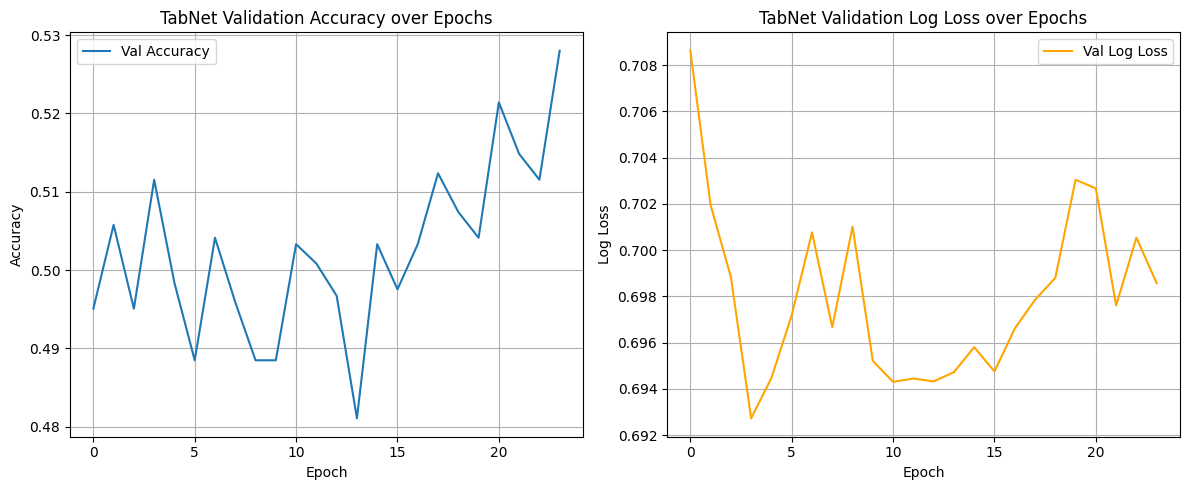

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


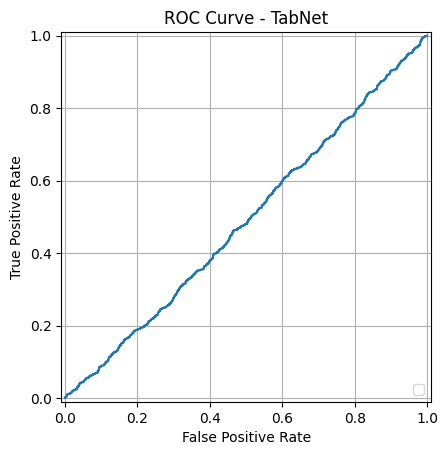

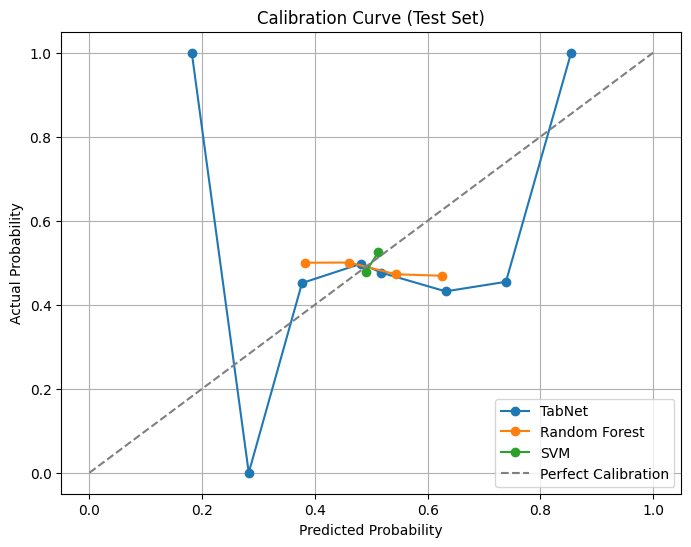

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, RocCurveDisplay

# --- Accuracy & Log Loss over Epochs (TabNet) ---
history = tabnet_model.history

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('TabNet Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Log Loss
plt.subplot(1, 2, 2)
plt.plot(history['val_logloss'], label='Val Log Loss', color='orange')
plt.title('TabNet Validation Log Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# --- ROC Curve (TabNet only) ---
fpr, tpr, _ = roc_curve(y_test, tabnet_test_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title("ROC Curve - TabNet")
plt.grid(True)
plt.show()


# --- Calibration Curve (All Models) ---
plt.figure(figsize=(8, 6))

# TabNet
prob_true_tab, prob_pred_tab = calibration_curve(y_test, tabnet_test_proba, n_bins=10)
plt.plot(prob_pred_tab, prob_true_tab, marker='o', label='TabNet')

# Random Forest
prob_true_rf, prob_pred_rf = calibration_curve(y_test, rf_test_proba, n_bins=10)
plt.plot(prob_pred_rf, prob_true_rf, marker='o', label='Random Forest')

# SVM
prob_true_svm, prob_pred_svm = calibration_curve(y_test, svm_test_proba, n_bins=10)
plt.plot(prob_pred_svm, prob_true_svm, marker='o', label='SVM')

# Perfect Calibration Line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

plt.title('Calibration Curve (Test Set)')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.legend()
plt.grid(True)
plt.show()


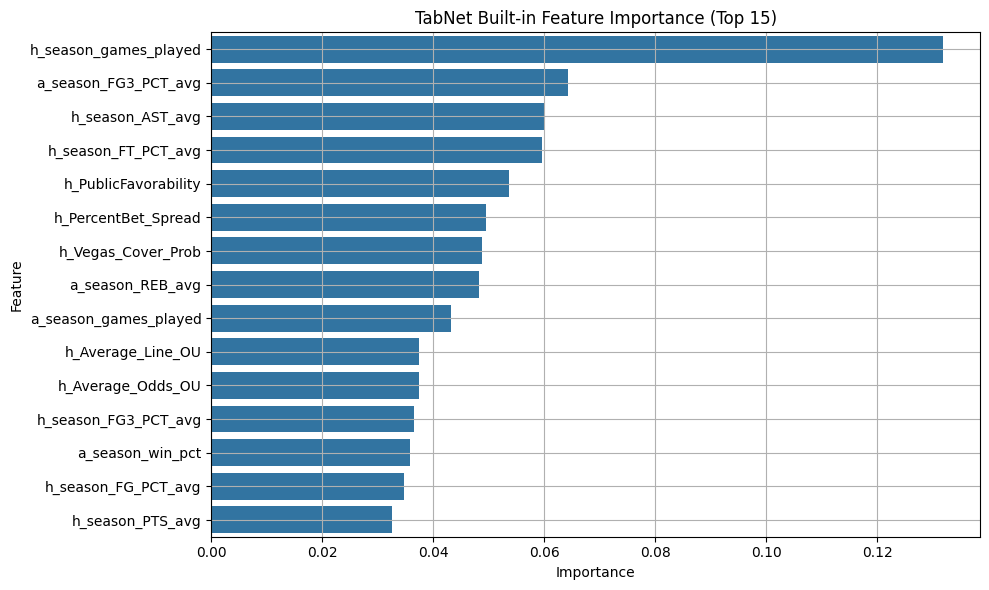

In [524]:
import seaborn as sns

# Get built-in feature importances
tabnet_feat_importance = tabnet_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': tabnet_feat_importance
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importance_df.head(15), x='Importance', y='Feature')
plt.title('TabNet Built-in Feature Importance (Top 15)')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/sj/xc1pvfqd479gs7_4_rxlkx_c0000gn/T/ipykernel_11694/1640013898.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_scaled, feature_names=X_test_scaled.columns, max_display=10)


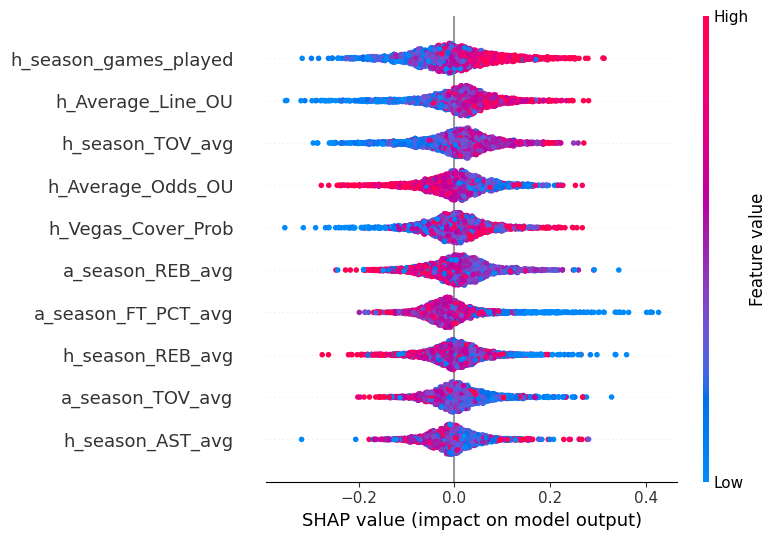

In [ ]:
import shap

# Use the deep explainer for TabNet
explainer = shap.Explainer(tabnet_model.predict, X_test_scaled.values.astype(np.float32))

# Compute SHAP values
shap_values = explainer(X_test_scaled.values.astype(np.float32))

# Summary plot
shap.summary_plot(shap_values.values, X_test_scaled, feature_names=X_test_scaled.columns, max_display=10)


In [ ]:
from datetime import timedelta

def simulate_betting(model, df, model_features, strategy="fixed", edge=0.02,
                     kelly_fraction=1/8, fixed_wager=100, starting_bankroll=1000,
                     reinvest_same_day=False, max_wager = 1000000):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)

    # Predict probabilities
    X = df[model_features].to_numpy(dtype=np.float32)
    df["predicted_prob"] = model.predict_proba(X)[:, 1]
    df["actual"] = df["h_cover"]

    # Convert moneyline odds to implied probabilities
    def moneyline_to_prob(odds):
        return np.where(
            odds >= 100,
            100 / (odds + 100),
            -odds / (-odds + 100)
        )

    df["odds"] = df["h_Average_Odds_Spread"]
    df["vegas_prob"] = moneyline_to_prob(df["odds"])

    # Define when to bet and bet direction
    df["should_bet"] = (df["predicted_prob"] - df["vegas_prob"]).abs() > edge
    df["bet_on_cover"] = df["predicted_prob"] > df["vegas_prob"]

    bankroll = starting_bankroll
    bankroll_history = []
    bet_log = []
    daily_payouts = {}

    for date, group in df.groupby("Date"):
        # Add previous day's payouts
        if date in daily_payouts:
            bankroll += daily_payouts.pop(date)

        available_bankroll = bankroll
        payout_tomorrow = 0

        for _, row in group.iterrows():
            if not row["should_bet"] or available_bankroll <= 0:
                continue

            odds = row["odds"]
            decimal_odds = (odds / 100 + 1) if odds >= 100 else (100 / abs(odds) + 1)

            # Bet amount
            if strategy == "kelly":
                p = row["predicted_prob"] if row["bet_on_cover"] else 1 - row["predicted_prob"]
                q = 1 - p
                b = decimal_odds - 1
                kelly = max((b * p - q) / b, 0)
                bet_amt = available_bankroll * kelly * kelly_fraction
            else:
                bet_amt = min(fixed_wager, available_bankroll)
            
            bet_amt = min(bet_amt, max_wager)

            if bet_amt <= 0:
                continue

            # Outcome
            win = (row["actual"] == 1) if row["bet_on_cover"] else (row["actual"] == 0)
            profit = bet_amt * (decimal_odds - 1) if win else -bet_amt
            payout = bet_amt + profit if win else 0
            payout_tomorrow += payout
            if not reinvest_same_day:
                available_bankroll -= bet_amt
            else:
                bankroll -= bet_amt

            bet_log.append({
                "Date": date,
                "GameId": row["GAME_ID"],
                "Odds": odds,
                "BetAmount": bet_amt,
                "Win": win,
                "Profit": profit,
                "ModelProb": row["predicted_prob"],
                "VegasProb": row["vegas_prob"],
                "Strategy": strategy,
                "Model": model.__class__.__name__
            })

        bankroll = available_bankroll
        bankroll_history.append({"Date": date, "Bankroll": bankroll})
        next_day = date + timedelta(days=1)
        daily_payouts[next_day] = daily_payouts.get(next_day, 0) + payout_tomorrow

    # Add future payouts
    for payout_date in sorted(daily_payouts):
        bankroll += daily_payouts[payout_date]
        bankroll_history.append({"Date": payout_date, "Bankroll": bankroll})

    roi = (bankroll - starting_bankroll) / starting_bankroll * 100
    print(f"\n {model.__class__.__name__} ({strategy.capitalize()} Betting):")
    print(f"  Final Bankroll: ${bankroll:.2f}")
    print(f"  ROI: {roi:.2f}%")
    print(f"  Total Bets Placed: {len(bet_log)}")

    return pd.DataFrame(bankroll_history), pd.DataFrame(bet_log)


In [409]:
df_test.columns

Index(['GAME_ID', 'Date', 'Year', 'GAME_SEQUENCE', 'h_TEAM_ID',
       'h_TEAM_ABBREVIATION', 'h_TEAM_CITY_NAME', 'a_TEAM_ID',
       'a_TEAM_ABBREVIATION', 'a_TEAM_CITY_NAME', 'h_PercentBet_ML',
       'h_PercentBet_Spread', 'h_Average_Line_Spread', 'h_Average_Odds_Spread',
       'h_PercentBet_OU', 'h_Average_Line_OU', 'h_Average_Odds_OU',
       'h_season_games_played', 'a_season_games_played', 'h_season_win_pct',
       'a_season_win_pct', 'h_season_PTS_avg', 'h_season_FG_PCT_avg',
       'h_season_FT_PCT_avg', 'h_season_FG3_PCT_avg', 'h_season_AST_avg',
       'h_season_REB_avg', 'h_season_TOV_avg', 'a_season_PTS_avg',
       'a_season_FG_PCT_avg', 'a_season_FT_PCT_avg', 'a_season_FG3_PCT_avg',
       'a_season_AST_avg', 'a_season_REB_avg', 'a_season_TOV_avg', 'h_cover',
       'over_result', 'h_Result', 'h_Vegas_Win_Prob', 'h_Vegas_Cover_Prob'],
      dtype='object')

In [549]:
# Required features for model input
model_features = X_train_scaled.columns.tolist()

# TabNet
tabnet_bankroll_kelly, tabnet_bets_kelly = simulate_betting(
    model=tabnet_model,
    df=df_test,
    model_features=model_features,
    strategy="kelly"
)

tabnet_bankroll_fixed, tabnet_bets_fixed = simulate_betting(
    model=tabnet_model,
    df=df_test,
    model_features=model_features,
    strategy="fixed"
)

# SVM
svm_bankroll_kelly, svm_bets_kelly = simulate_betting(
    model=svm_model,
    df=df_test,
    model_features=model_features,
    strategy="kelly",
    edge = 0
)

svm_bankroll_fixed, svm_bets_fixed = simulate_betting(
    model=svm_model,
    df=df_test,
    model_features=model_features,
    strategy="fixed"
)

# Random Forest
rf_bankroll_kelly, rf_bets_kelly = simulate_betting(
    model=rf_model,
    df=df_test,
    model_features=model_features,
    strategy="kelly"
)

rf_bankroll_fixed, rf_bets_fixed = simulate_betting(
    model=rf_model,
    df=df_test,
    model_features=model_features,
    strategy="fixed"
)



 TabNetClassifier (Kelly Betting):
  Final Bankroll: $231.14
  ROI: -76.89%
  Total Bets Placed: 2102

 TabNetClassifier (Fixed Betting):
  Final Bankroll: $576.82
  ROI: -42.32%
  Total Bets Placed: 226


/Users/lathangregg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



 SVC (Kelly Betting):
  Final Bankroll: $1000.00
  ROI: 0.00%
  Total Bets Placed: 0


/Users/lathangregg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



 SVC (Fixed Betting):
  Final Bankroll: $164.00
  ROI: -83.60%
  Total Bets Placed: 212


/Users/lathangregg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



 RandomForestClassifier (Kelly Betting):
  Final Bankroll: $847.39
  ROI: -15.26%
  Total Bets Placed: 626


/Users/lathangregg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



 RandomForestClassifier (Fixed Betting):
  Final Bankroll: $0.00
  ROI: -100.00%
  Total Bets Placed: 57


In [551]:
# calculate win rates
print("TabNet Kelly Win Rate:", tabnet_bets_kelly['Win'].mean())
print("TabNet Fixed Win Rate:", tabnet_bets_fixed['Win'].mean())
print("SVM Fixed Win Rate:", svm_bets_fixed['Win'].mean())
print("RF Kelly Win Rate:", rf_bets_kelly['Win'].mean())
print("RF Fixed Win Rate:", rf_bets_fixed['Win'].mean())


TabNet Kelly Win Rate: 0.5080875356803045
TabNet Fixed Win Rate: 0.5088495575221239
SVM Fixed Win Rate: 0.49528301886792453
RF Kelly Win Rate: 0.5159744408945687
RF Fixed Win Rate: 0.42105263157894735


In [543]:
tabnet_bets_kelly

,Date,GameId,Odds,BetAmount,Win,Profit,ModelProb,VegasProb,Strategy,Model
0,2017-10-20,21700017,-105.33,1.242300e+02,True,1.179436e+02,9.969999e-01,0.512979,kelly,TabNetClassifier
1,2017-10-20,21700018,-106.67,7.631118e+01,False,-7.631118e+01,8.534324e-01,0.516137,kelly,TabNetClassifier
2,2017-10-20,21700019,-108.00,8.408768e+00,True,7.785896e+00,4.403151e-01,0.519231,kelly,TabNetClassifier
3,2017-10-20,21700020,-108.83,9.888122e+01,True,9.085842e+01,2.024793e-07,0.521142,kelly,TabNetClassifier
4,2017-10-20,21700021,-108.00,2.757139e+01,True,2.552907e+01,3.275641e-01,0.519231,kelly,TabNetClassifier
...,...,...,...,...,...,...,...,...,...,...
2097,2019-04-10,21801221,-105.67,1.596872e-07,False,-1.596872e-07,3.283653e-02,0.513784,kelly,TabNetClassifier
2098,2019-04-10,21801223,-105.67,1.512911e-07,True,1.431732e-07,2.264942e-06,0.513784,kelly,TabNetClassifier
2099,2019-04-10,21801224,-110.17,1.278679e-07,False,-1.278679e-07,1.621899e-02,0.524195,kelly,TabNetClassifier
2100,2019-04-10,21801226,-105.83,8.212680e-08,True,7.760257e-08,1.430427e-01,0.514162,kelly,TabNetClassifier


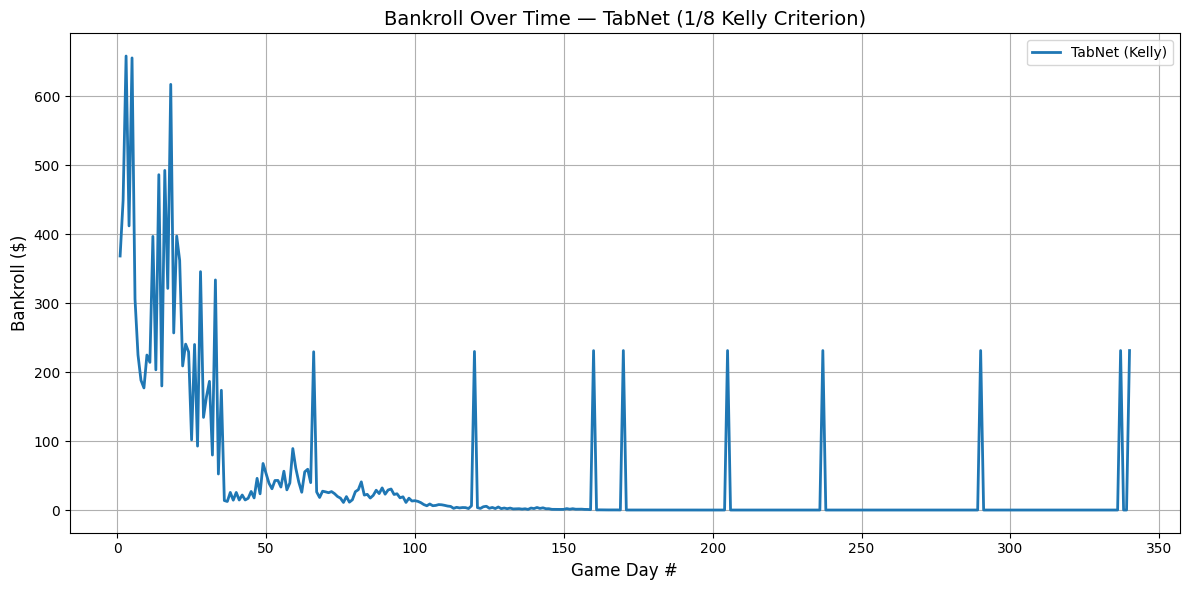

In [536]:
# Step 1: Convert to sequential Game Day #
bankroll_df_sorted = tabnet_bankroll_kelly.sort_values("Date").reset_index(drop=True)
bankroll_df_sorted["GameDay"] = range(1, len(bankroll_df_sorted) + 1)

# Step 2: Plot bankroll vs Game Day #
plt.figure(figsize=(12, 6))
plt.plot(bankroll_df_sorted["GameDay"], bankroll_df_sorted["Bankroll"], label='TabNet (Kelly)', linewidth=2)

# Formatting
plt.title("Bankroll Over Time — TabNet (1/8 Kelly Criterion)", fontsize=14)
plt.xlabel("Game Day #", fontsize=12)
plt.ylabel("Bankroll ($)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [537]:
bankroll_df_sorted

,Date,Bankroll,GameDay
0,2017-10-20,3.682091e+02,1
1,2017-10-21,4.485485e+02,2
2,2017-10-22,6.580298e+02,3
3,2017-10-23,4.118198e+02,4
4,2017-10-24,6.552912e+02,5
...,...,...,...
335,2019-04-07,1.079931e-06,336
336,2019-04-08,2.311368e+02,337
337,2019-04-09,4.290368e-07,338
338,2019-04-10,7.574572e-07,339


In [541]:
tabnet_bankroll_kelly

,Date,Bankroll
0,2017-10-20,368.209108
1,2017-10-21,448.548488
2,2017-10-22,658.029812
3,2017-10-23,411.819807
4,2017-10-24,655.291200
...,...,...
335,2018-11-22,231.136749
336,2018-12-24,231.136764
337,2019-02-15,231.136764
338,2019-04-08,231.136767


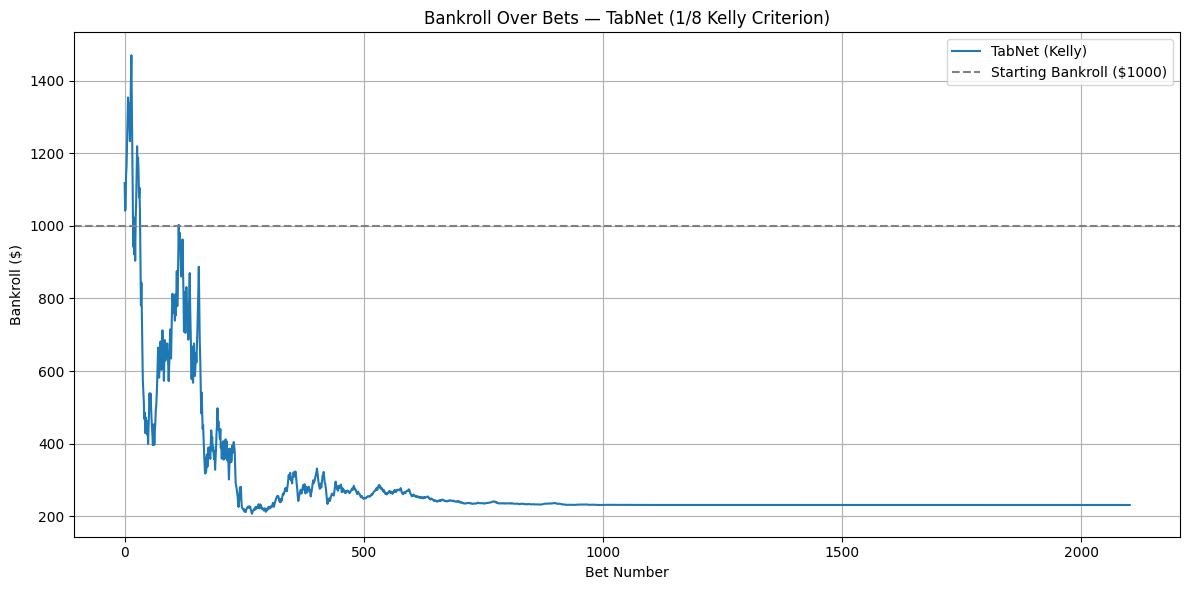

In [545]:
# Sort by date to ensure chronological order
bet_log_df_sorted = tabnet_bets_kelly.sort_values("Date").reset_index(drop=True)

# Cumulative bankroll: start with 1000 and add profit after each bet
initial_bankroll = 1000
bet_log_df_sorted["CumulativeBankroll"] = initial_bankroll + bet_log_df_sorted["Profit"].cumsum()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(bet_log_df_sorted.index, bet_log_df_sorted["CumulativeBankroll"], label="TabNet (Kelly)", linewidth=1.5)
plt.axhline(y=initial_bankroll, color='gray', linestyle='--', label='Starting Bankroll ($1000)')

plt.xlabel("Bet Number")
plt.ylabel("Bankroll ($)")
plt.title("Bankroll Over Bets — TabNet (1/8 Kelly Criterion)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# OLD CODE

In [289]:
df.head()

,GAME_ID,Date,Year,GAME_SEQUENCE,h_TEAM_ID,h_TEAM_ABBREVIATION,h_TEAM_CITY_NAME,a_TEAM_ID,a_TEAM_ABBREVIATION,a_TEAM_CITY_NAME,h_PercentBet_ML,h_PercentBet_Spread,h_Average_Line_Spread,h_PercentBet_OU,h_Average_Line_OU,h_Average_Odds_OU,h_season_games_played,a_season_games_played,h_season_win_pct,a_season_win_pct,h_season_PTS_avg,h_season_FG_PCT_avg,h_season_FT_PCT_avg,h_season_FG3_PCT_avg,h_season_AST_avg,h_season_REB_avg,h_season_TOV_avg,a_season_PTS_avg,a_season_FG_PCT_avg,a_season_FT_PCT_avg,a_season_FG3_PCT_avg,a_season_AST_avg,a_season_REB_avg,a_season_TOV_avg,h_cover,over_result,h_Result,h_Vegas_Win_Prob,h_Vegas_Cover_Prob
0,21200001,2012-10-30,2012-2013,1,1610612739,CLE,Cleveland,1610612764,WAS,Washington,55.4,55.6,-5.83,52.7,190.33,-110.17,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0.687201,0.502551
1,21200002,2012-10-30,2012-2013,2,1610612748,MIA,Miami,1610612738,BOS,Boston,55.2,51.8,-6.58,48.4,186.58,-109.33,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0.709567,0.499634
2,21200003,2012-10-30,2012-2013,3,1610612747,LAL,Los Angeles,1610612742,DAL,Dallas,59.2,51.0,-8.75,57.4,186.00,-109.17,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0.804325,0.502581
3,21200004,2012-10-31,2012-2013,1,1610612761,TOR,Toronto,1610612754,IND,Indiana,58.1,48.5,1.92,46.5,189.75,-108.50,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.552139,0.502924
4,21200005,2012-10-31,2012-2013,2,1610612755,PHI,Philadelphia,1610612743,DEN,Denver,46.6,41.6,1.25,52.9,197.83,-110.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0.459660,0.497076


In [290]:
df_final.columns

Index(['GAME_ID', 'Date', 'Year', 'GAME_SEQUENCE', 'h_TEAM_ID',
       'h_TEAM_ABBREVIATION', 'h_TEAM_CITY_NAME', 'a_TEAM_ID',
       'a_TEAM_ABBREVIATION', 'a_TEAM_CITY_NAME', 'h_PercentBet_ML',
       'h_Open_Line_ML', 'h_Average_Line_ML', 'h_Best_Line_ML',
       'h_Worst_Line_ML', 'h_PercentBet_Spread', 'h_Open_Line_Spread',
       'h_Open_Odds_Spread', 'h_Average_Line_Spread', 'h_Average_Odds_Spread',
       'h_Best_Line_Spread', 'h_Worst_Line_Spread', 'h_Best_Odds_Spread',
       'h_Worst_Odds_Spread', 'h_PercentBet_OU', 'h_Open_Line_OU',
       'h_Open_Odds_OU', 'h_Average_Line_OU', 'h_Average_Odds_OU',
       'h_Best_Line_OU', 'h_Worst_Line_OU', 'h_Best_Odds_OU',
       'h_Worst_Odds_OU', 'a_PercentBet_ML', 'a_Open_Line_ML',
       'a_Average_Line_ML', 'a_Best_Line_ML', 'a_Worst_Line_ML',
       'a_PercentBet_Spread', 'a_Open_Line_Spread', 'a_Open_Odds_Spread',
       'a_Average_Line_Spread', 'a_Average_Odds_Spread', 'a_Best_Line_Spread',
       'a_Worst_Line_Spread', 'a_Best_O

In [3]:
combined_df = combined_df.drop(columns=columns_to_drop, errors='ignore')

combined_df['h_cover'] = np.where((combined_df['h_PTS'] + combined_df['h_Average_Line_Spread'] - combined_df['a_PTS']) > 0, 1, 0)
combined_df['over_cover'] = np.where(combined_df['Total'] > combined_df['Average_Line_OU'], 1, 0)

cols_to_drop = ['h_PTS', 'a_PTS', 'h_LOSSES', 'h_Spread', 'Total', 'a_Spread', 'a_Pts', 'h_Pts']
combined_df = combined_df.drop(columns=cols_to_drop)

def moneyline_to_probability(odds):
    """Convert moneyline odds to implied probability (vectorized for arrays)."""
    return np.where(
        odds < 0,
        -odds / (-odds + 100),
        100 / (odds + 100)
    )

# Convert both home and away moneyline odds to implied probabilities
home_probs = moneyline_to_probability(combined_df['h_Average_Line_ML'])
away_probs = moneyline_to_probability(combined_df['a_Average_Line_ML'])

# Normalize to remove the vig (so that home + away = 1)
total_probs = home_probs + away_probs
combined_df['h_Implied_Prob_ML'] = home_probs / total_probs

if combined_df['h_PercentBet_ML'].max() > 1:
    combined_df['h_PercentBet_ML'] = combined_df['h_PercentBet_ML'] / 100.0
    
eps = 1e-6
p_public = combined_df['h_PercentBet_ML'].clip(eps, 1 - eps)
p_vegas = combined_df['h_Implied_Prob_ML'].clip(eps, 1 - eps)

# Log-odds based favorability
combined_df['h_PublicFavorability'] = np.log(p_public / (1 - p_public)) - np.log(p_vegas / (1 - p_vegas))

KeyError: 'h_Average_Line_Spread'

In [ ]:
# Re-import everything after kernel reset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
from datetime import datetime
import torch

# Note: This assumes combined_df has already been defined earlier in your notebook.
# Please re-run the combined_df preparation if necessary before running this cell.

# -------------------------
# DATA SPLITTING & PREP
# -------------------------

# Split data
train_years = ['2012-2013', '2013-2014', '2014-2015', '2015-2016']
val_years = ['2016-2017']
test_years = ['2017-2018', '2018-2019']

df_train = combined_df[combined_df['YEAR'].isin(train_years)].copy()
df_val = combined_df[combined_df['YEAR'].isin(val_years)].copy()
df_test = combined_df[combined_df['YEAR'].isin(test_years)].copy()

print(f"Train shape: {df_train.shape}")
print(f"Val shape:   {df_val.shape}")
print(f"Test shape:  {df_test.shape}")

# Define modeling features and simulation metadata
model_features = [
    'a_season_FG_PCT_avg', 'a_season_FT_PCT_avg', 'a_season_FG3_PCT_avg',
    'a_WIN_PCT', 'a_WIN_PCT_LAST10', 'h_season_FG_PCT_avg',
    'h_season_FT_PCT_avg', 'h_season_FG3_PCT_avg', 'h_WIN_PCT',
    'h_WIN_PCT_LAST10', 'h_PercentBet_ML', 'h_PercentBet_Spread',
    'h_Average_Line_OU', 'a_PercentBet_ML', 'a_PercentBet_Spread',
    'a_Average_Odds_OU', 'h_Implied_Prob_ML', 'h_PublicFavorability'
]

simulation_columns = ['Date', 'GameId', 'h_Average_Odds_Spread', 'h_cover']

# Save full test set for simulation
df_test_full = df_test[model_features + simulation_columns].dropna()

# Drop unused columns for training
drop_cols = ['YEAR', 'Date', 'GameId'] + [
    col for col in combined_df.columns if 'OU' in col and col not in ['h_Average_Line_OU', 'a_Average_Odds_OU']
] + [
    col for col in combined_df.columns if ('Line' in col or 'Odds' in col) and col not in ['h_Average_Line_OU', 'a_Average_Odds_OU']
]
drop_cols = list(set(drop_cols))

df_train.drop(columns=drop_cols, inplace=True, errors='ignore')
df_val.drop(columns=drop_cols, inplace=True, errors='ignore')
df_test.drop(columns=drop_cols, inplace=True, errors='ignore')

# Remove NaNs
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)
df_test.dropna(inplace=True)

# Define X and y
X_train = df_train.drop(columns=['h_cover'])
y_train = df_train['h_cover'].astype(int)

X_val = df_val.drop(columns=['h_cover'])
y_val = df_val['h_cover'].astype(int)

X_test = df_test.drop(columns=['h_cover'])
y_test = df_test['h_cover'].astype(int)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to numpy
X_train_np = X_train_scaled.astype(np.float32)
X_val_np = X_val_scaled.astype(np.float32)
X_test_np = X_test_scaled.astype(np.float32)
y_train = y_train.to_numpy(dtype=np.int64)
y_val = y_val.to_numpy(dtype=np.int64)
y_test = y_test.to_numpy(dtype=np.int64)

# -------------------------
# MODEL TRAINING
# -------------------------

tabnet_model = TabNetClassifier(
    device_name='cuda' if torch.cuda.is_available() else 'cpu',
    seed=42,
    verbose=1
)

tabnet_model.fit(
    X_train=X_train_np,
    y_train=y_train,
    eval_set=[(X_val_np, y_val)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=20,
    batch_size=128,
    virtual_batch_size=32,
    num_workers=0
)

# -------------------------
# SIMULATION INPUT PREP
# -------------------------

X_sim = df_test_full[model_features]
X_sim_np = scaler.transform(X_sim).astype(np.float32)

df_sim_input = pd.concat([
    df_test_full[['Date', 'GameId', 'h_Average_Odds_Spread']].reset_index(drop=True),
    pd.DataFrame(X_sim_np, columns=model_features)
], axis=1)

y_sim_true = df_test_full['h_cover'].to_numpy(dtype=np.int64)


In [ ]:
# Set the root directory of your repo as part of the path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

data = pd.read_csv('../Data/combined/full_lathan.csv')

vegas = pd.read_csv('../Data/combined/full_vegas_data.csv')
vegas = vegas.sort_values(by=['GameId', 'Location'])

# --- Step 1: Define shared columns (same across home/away teams) ---
shared_columns = ['Total', 'Worst_Line_OU', 'Best_Line_OU', 'Average_Line_OU']

# --- Step 2: Split into home and away teams ---
df_home = vegas[vegas['Location'] == 'home'].copy()
df_away = vegas[vegas['Location'] == 'away'].copy()

# --- Step 3: Drop shared columns from away team to avoid duplication ---
df_home = df_home.drop(columns=['Location'])  # Don't need location after naming
df_away = df_away.drop(columns=shared_columns + ['Location'])

# --- Step 4: Prefix all columns (except identifiers) ---
home_prefix = 'h_'
away_prefix = 'a_'
id_cols = ['GameId']  # Columns to merge on

df_home = df_home.rename(columns={col: home_prefix + col for col in df_home.columns if col not in id_cols})
df_away = df_away.rename(columns={col: away_prefix + col for col in df_away.columns if col not in id_cols})

# --- Step 5: Merge home and away teams on GameId ---
df_merged = pd.merge(df_home, df_away, on='GameId', how='inner')

# --- Step 6: Add shared columns (only from home, since they're the same) ---
shared_data = vegas[vegas['Location'] == 'home'][['GameId'] + shared_columns]
df_final = pd.merge(df_merged, shared_data, on='GameId', how='left')

# Optional: reorder columns to start with GameId
cols = ['GameId'] + [col for col in df_final.columns if col != 'GameId']
vegas = df_final[cols]

from src.data.preprocess import (
    create_ml_dataset

)

data2 = create_ml_dataset(data)

data2 = data2.drop(columns=['GAME_DATE_EST'])

combined_df = pd.merge(data2, vegas, left_on = 'GAME_ID',right_on='GameId', how='left')

books_to_drop = ['Pinnacle', '5dimes', 'Heritage', 'Bovada', 'Betonline']

# --- Step 2: Identify columns to drop ---
columns_to_drop = [col for col in combined_df.columns if any(book in col for book in books_to_drop)]

# --- Step 3: Drop those columns from the DataFrame ---
combined_df = combined_df.drop(columns=columns_to_drop)
columns_to_drop = [col for col in combined_df.columns if any(book in col for book in books_to_drop)]
combined_df = combined_df.drop(columns=columns_to_drop)

columns_to_drop = ['a_FG_PCT', 'a_FT_PCT','a_FG3_PCT', 'a_AST', 'a_REB', 'a_TOV','GAME_ID', 'h_FG_PCT', 
                   'h_FT_PCT', 'h_FG3_PCT','h_AST', 'h_REB', 'h_TOV',
                   'GAME_SEQUENCE', 'Date', 'a_index', 'a_TEAM_ID','h_TEAM_ID', 'a_TEAM_WINS_LOSSES',
                  'h_TEAM_WINS_LOSSES', 'IS_PLAYOFF_GAME', 'h_index', 'HOME_WIN', 'a_SEASON_GAMES_PLAYED', 'h_SEASON_GAMES_PLAYED', 
                  'a_WINS', 'a_LOSSES', 'h_WINS', 'a_SEASON_GAMES_PLAYED', 'h_SEASON_GAMES_PLAYED', 'a_season_PTS_lag', 'a_season_AST_lag', 
                  'a_season_REB_lag', 'a_season_TOV_lag', 'h_season_PTS_lag', 'h_season_AST_lag', 'h_season_REB_lag', 'h_season_TOV_lag', 'GameId', 
                  'h_Date', 'h_Team', 'h_OppTeam', 'h_TeamId', 'h_YEAR', 'h_Result', 'h_Total', 'a_Date', 'a_Team', 'a_OppTeam', 'a_TeamId', 'a_YEAR', 'a_Result']
combined_df = combined_df.drop(columns=columns_to_drop)

combined_df['h_cover'] = np.where((combined_df['h_PTS'] + combined_df['h_Average_Line_Spread'] - combined_df['a_PTS']) > 0, 1, 0)
combined_df['over_cover'] = np.where(combined_df['Total'] > combined_df['Average_Line_OU'], 1, 0)

cols_to_drop = ['h_PTS', 'a_PTS', 'h_LOSSES', 'h_Spread', 'Total', 'a_Spread', 'a_Pts', 'h_Pts']
combined_df = combined_df.drop(columns=cols_to_drop)

def moneyline_to_probability(odds):
    """Convert moneyline odds to implied probability (vectorized for arrays)."""
    return np.where(
        odds < 0,
        -odds / (-odds + 100),
        100 / (odds + 100)
    )

# Convert both home and away moneyline odds to implied probabilities
home_probs = moneyline_to_probability(combined_df['h_Average_Line_ML'])
away_probs = moneyline_to_probability(combined_df['a_Average_Line_ML'])

# Normalize to remove the vig (so that home + away = 1)
total_probs = home_probs + away_probs
combined_df['h_Implied_Prob_ML'] = home_probs / total_probs

if combined_df['h_PercentBet_ML'].max() > 1:
    combined_df['h_PercentBet_ML'] = combined_df['h_PercentBet_ML'] / 100.0
    
eps = 1e-6
p_public = combined_df['h_PercentBet_ML'].clip(eps, 1 - eps)
p_vegas = combined_df['h_Implied_Prob_ML'].clip(eps, 1 - eps)

# Log-odds based favorability
combined_df['h_PublicFavorability'] = np.log(p_public / (1 - p_public)) - np.log(p_vegas / (1 - p_vegas))

combined_df.drop(columns=['h_Pts', 'a_Pts', 'over_cover'], inplace=True)



# STEP 1: Split into train/val/test based on YEAR
train_years = ['2012-2013', '2013-2014', '2014-2015', '2015-2016']
val_years = ['2016-2017']
test_years = ['2017-2018', '2018-2019']

df_train = combined_df[combined_df['YEAR'].isin(train_years)].copy()
df_val = combined_df[combined_df['YEAR'].isin(val_years)].copy()
df_test = combined_df[combined_df['YEAR'].isin(test_years)].copy()

# CHECK: Are the splits roughly expected sizes?
print(f"Train shape: {df_train.shape}")
print(f"Val shape:   {df_val.shape}")
print(f"Test shape:  {df_test.shape}")

# STEP 2: Drop YEAR, and all columns with 'OU' (except average), and lines/odds
columns_to_drop = ['YEAR']
columns_to_drop += [col for col in combined_df.columns if 'OU' in col and col not in ['h_Average_Line_OU', 'a_Average_Odds_OU']]
columns_to_drop += [col for col in combined_df.columns if ('Line' in col or 'Odds' in col) and col not in ['h_Average_Line_OU', 'a_Average_Odds_OU']]
columns_to_drop = list(set(columns_to_drop))  # remove duplicates

df_train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
df_val.drop(columns=columns_to_drop, inplace=True, errors='ignore')
df_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')


# CHECK: Remaining columns
print("Remaining columns:", df_train.columns.tolist())

# STEP 3: Drop NaNs
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)
df_test.dropna(inplace=True)

# Separate target from predictors
target_col = 'h_cover'
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col].astype(int)

X_val = df_val.drop(columns=[target_col])
y_val = df_val[target_col].astype(int)

X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col].astype(int)

# CHECK: Ensure no missing values or object columns remain
print("Any NaNs in train?", X_train.isna().any().any())
print("Object cols in train:", X_train.select_dtypes(include='object').columns.tolist())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# STEP 2: Apply to val and test
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# STEP 3: Convert to float32 NumPy arrays (for TabNet)
X_train_np = X_train_scaled.astype(np.float32)
X_val_np = X_val_scaled.astype(np.float32)
X_test_np = X_test_scaled.astype(np.float32)

# STEP 4: Convert labels to int64
y_train = np.array(y_train).astype(np.int64)
y_val = np.array(y_val).astype(np.int64)
y_test = np.array(y_test).astype(np.int64)

In [ ]:
# STEP 1: Split into train/val/test based on YEAR
train_years = ['2012-2013', '2013-2014', '2014-2015', '2015-2016']
val_years = ['2016-2017']
test_years = ['2017-2018', '2018-2019']

df_train = combined_df[combined_df['YEAR'].isin(train_years)].copy()
df_val = combined_df[combined_df['YEAR'].isin(val_years)].copy()
df_test = combined_df[combined_df['YEAR'].isin(test_years)].copy()

# CHECK: Are the splits roughly expected sizes?
print(f"Train shape: {df_train.shape}")
print(f"Val shape:   {df_val.shape}")
print(f"Test shape:  {df_test.shape}")

# Save a version of df_test before dropping columns for simulation
# These are the features you used in the model
model_features = [
    'a_season_FG_PCT_avg', 'a_season_FT_PCT_avg', 'a_season_FG3_PCT_avg',
    'a_WIN_PCT', 'a_WIN_PCT_LAST10', 'h_season_FG_PCT_avg',
    'h_season_FT_PCT_avg', 'h_season_FG3_PCT_avg', 'h_WIN_PCT',
    'h_WIN_PCT_LAST10', 'h_PercentBet_ML', 'h_PercentBet_Spread',
    'h_Average_Line_OU', 'a_PercentBet_ML', 'a_PercentBet_Spread',
    'a_Average_Odds_OU', 'h_Implied_Prob_ML', 'h_PublicFavorability'
]

# Features required for simulation (metadata + outcome)
simulation_extras = ['Date', 'GameId', 'h_Average_Odds_Spread', 'h_cover']

# Make sure we include only columns present in df_test
available_cols = df_test.columns.tolist()
needed_cols = model_features + [col for col in simulation_extras if col in available_cols]

# Create df_test_full for use in the simulation
df_test_full = df_test[needed_cols].dropna()

# STEP 2: Drop YEAR, and all columns with 'OU' (except average), and lines/odds
columns_to_drop = ['YEAR', 'Date', 'GameId']
columns_to_drop += [col for col in combined_df.columns if 'OU' in col and col not in ['h_Average_Line_OU', 'a_Average_Odds_OU']]
columns_to_drop += [col for col in combined_df.columns if ('Line' in col or 'Odds' in col) and col not in ['h_Average_Line_OU', 'a_Average_Odds_OU']]
columns_to_drop = list(set(columns_to_drop))  # remove duplicates

df_train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
df_val.drop(columns=columns_to_drop, inplace=True, errors='ignore')
df_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

df_train.drop(columns = 'Date', inplace=True, errors='ignore')
df_val.drop(columns = 'Date', inplace=True, errors='ignore')
df_test.drop(columns = 'Date', inplace=True, errors='ignore')

# STEP 3: Drop NaNs
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)
df_test.dropna(inplace=True)

# Separate target from predictors
target_col = 'h_cover'
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col].astype(int)

X_val = df_val.drop(columns=[target_col])
y_val = df_val[target_col].astype(int)

X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col].astype(int)

# CHECK: Ensure no missing values or object columns remain
print("Any NaNs in train?", X_train.isna().any().any())
print("Object cols in train:", X_train.select_dtypes(include='object').columns.tolist())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# STEP 2: Apply to val and test
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# STEP 3: Convert to float32 NumPy arrays (for TabNet)
X_train_np = X_train_scaled.astype(np.float32)
X_val_np = X_val_scaled.astype(np.float32)
X_test_np = X_test_scaled.astype(np.float32)

# STEP 4: Convert labels to int64
y_train = np.array(y_train).astype(np.int64)
y_val = np.array(y_val).astype(np.int64)
y_test = np.array(y_test).astype(np.int64)

# Create and train the model
tabnet_model = TabNetClassifier(
    device_name='cuda' if torch.cuda.is_available() else 'cpu',
    seed=42,
    verbose=1
)

tabnet_model.fit(
    X_train=X_train_np,
    y_train=y_train,
    eval_set=[(X_val_np, y_val)],
    eval_name=[('train', 'val')],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=20,
    batch_size=128,
    virtual_batch_size=32,
    num_workers=0
)

import pandas as pd
import numpy as np
from datetime import datetime

def simulate_realistic_betting(model, df_features, y_true, model_name="Model", kelly_fraction=1/8):
    # Assumes df_features includes Date, Average_Odds_Spread, and predicted features
    df = df_features.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    
    # Step 1: Predict probabilities of home team covering
    probs = model.predict_proba(df.drop(columns=["Date", "h_Average_Odds_Spread", "Spread", "Result"], errors='ignore').values)[:, 1]
    df["predicted_prob"] = probs
    df["actual"] = y_true
    df["odds"] = df["h_Average_Odds_Spread"]
    
    # Step 2: Convert spread odds to implied probabilities
    def odds_to_implied_prob(o):
        if o >= 100:
            return 100 / (o + 100)
        else:
            return -o / (-o + 100)
    
    df["vegas_prob"] = df["odds"].apply(odds_to_implied_prob)
    
    # Step 3: Determine if a bet should be made
    df["should_bet"] = ~((df["predicted_prob"] - df["vegas_prob"]).abs() < 0.02)  # Don't bet if close to market
    
    # Step 4: Determine bet direction
    df["bet_on_cover"] = df["predicted_prob"] > df["vegas_prob"]
    
    # Step 5: Sort by date to simulate daily betting
    df.sort_values("Date", inplace=True)
    bankroll = 1000.0
    daily_pending_payouts = {}
    bankroll_history = []
    bet_log = []
    
    for date, group in df.groupby("Date"):
        # Add payouts from previous dates
        if date in daily_pending_payouts:
            bankroll += daily_pending_payouts.pop(date)
        
        # Place bets for the day
        available_bankroll = bankroll
        payout_tomorrow = 0.0
        
        for _, row in group.iterrows():
            if not row["should_bet"] or available_bankroll <= 0:
                continue

            # Kelly-based bet size
            b = row["odds"] - 1
            p = row["predicted_prob"] if row["bet_on_cover"] else 1 - row["predicted_prob"]
            q = 1 - p
            kelly = (b * p - q) / b
            bet_fraction = max(kelly * kelly_fraction, 0)
            bet_amount = min(available_bankroll * bet_fraction, available_bankroll)

            if bet_amount <= 0:
                continue

            win = ((row["actual"] == 1) if row["bet_on_cover"] else (row["actual"] == 0))
            profit = bet_amount * b if win else -bet_amount
            payout_tomorrow += bet_amount + profit
            available_bankroll -= bet_amount

            bet_log.append({
                "Date": date,
                "GameId": row.get("GameId", None),
                "BetOnCover": row["bet_on_cover"],
                "BetAmount": bet_amount,
                "Odds": row["odds"],
                "ModelProb": row["predicted_prob"],
                "VegasProb": row["vegas_prob"],
                "Win": win,
                "Profit": profit
            })

        bankroll = available_bankroll
        bankroll_history.append((date, bankroll))
        next_day = date + pd.Timedelta(days=1)
        daily_pending_payouts[next_day] = daily_pending_payouts.get(next_day, 0) + payout_tomorrow

    # Add any remaining payouts
    for future_date, payout in sorted(daily_pending_payouts.items()):
        bankroll += payout
        bankroll_history.append((future_date, bankroll))

    # Final ROI
    roi = (bankroll - 1000) / 1000
    print(f"\n📊 {model_name} — Realistic Kelly Simulation:")
    print(f"  Final Bankroll: ${bankroll:.2f}")
    print(f"  ROI: {roi * 100:.2f}%")
    print(f"  Total Bets Placed: {len(bet_log)}")

    return pd.DataFrame(bankroll_history, columns=["Date", "Bankroll"]), pd.DataFrame(bet_log)


import pandas as pd
import numpy as np
from datetime import datetime

def simulate_realistic_betting(model, df_features, y_true, model_name="Model", kelly_fraction=1/8):
    # Assumes df_features includes Date, Average_Odds_Spread, and predicted features
    df = df_features.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    
    # Step 1: Predict probabilities of home team covering
    probs = model.predict_proba(df.drop(columns=["Date", "h_Average_Odds_Spread", "Spread", "Result"], errors='ignore').values)[:, 1]
    df["predicted_prob"] = probs
    df["actual"] = y_true
    df["odds"] = df["h_Average_Odds_Spread"]
    
    # Step 2: Convert spread odds to implied probabilities
    def odds_to_implied_prob(o):
        if o >= 100:
            return 100 / (o + 100)
        else:
            return -o / (-o + 100)
    
    df["vegas_prob"] = df["odds"].apply(odds_to_implied_prob)
    
    # Step 3: Determine if a bet should be made
    df["should_bet"] = ~((df["predicted_prob"] - df["vegas_prob"]).abs() < 0.02)  # Don't bet if close to market
    
    # Step 4: Determine bet direction
    df["bet_on_cover"] = df["predicted_prob"] > df["vegas_prob"]
    
    # Step 5: Sort by date to simulate daily betting
    df.sort_values("Date", inplace=True)
    bankroll = 1000.0
    daily_pending_payouts = {}
    bankroll_history = []
    bet_log = []
    
    for date, group in df.groupby("Date"):
        # Add payouts from previous dates
        if date in daily_pending_payouts:
            bankroll += daily_pending_payouts.pop(date)
        
        # Place bets for the day
        available_bankroll = bankroll
        payout_tomorrow = 0.0
        
        for _, row in group.iterrows():
            if not row["should_bet"] or available_bankroll <= 0:
                continue

            # Kelly-based bet size
            b = row["odds"] - 1
            p = row["predicted_prob"] if row["bet_on_cover"] else 1 - row["predicted_prob"]
            q = 1 - p
            kelly = (b * p - q) / b
            bet_fraction = max(kelly * kelly_fraction, 0)
            bet_amount = min(available_bankroll * bet_fraction, available_bankroll)

            if bet_amount <= 0:
                continue

            win = ((row["actual"] == 1) if row["bet_on_cover"] else (row["actual"] == 0))
            profit = bet_amount * b if win else -bet_amount
            payout_tomorrow += bet_amount + profit
            available_bankroll -= bet_amount

            bet_log.append({
                "Date": date,
                "GameId": row.get("GameId", None),
                "BetOnCover": row["bet_on_cover"],
                "BetAmount": bet_amount,
                "Odds": row["odds"],
                "ModelProb": row["predicted_prob"],
                "VegasProb": row["vegas_prob"],
                "Win": win,
                "Profit": profit
            })

        bankroll = available_bankroll
        bankroll_history.append((date, bankroll))
        next_day = date + pd.Timedelta(days=1)
        daily_pending_payouts[next_day] = daily_pending_payouts.get(next_day, 0) + payout_tomorrow

    # Add any remaining payouts
    for future_date, payout in sorted(daily_pending_payouts.items()):
        bankroll += payout
        bankroll_history.append((future_date, bankroll))

    # Final ROI
    roi = (bankroll - 1000) / 1000
    print(f"\n📊 {model_name} — Realistic Kelly Simulation:")
    print(f"  Final Bankroll: ${bankroll:.2f}")
    print(f"  ROI: {roi * 100:.2f}%")
    print(f"  Total Bets Placed: {len(bet_log)}")

    return pd.DataFrame(bankroll_history, columns=["Date", "Bankroll"]), pd.DataFrame(bet_log)


